## Final Project Submission

Please fill out:
* Student name: Kathy Lu
* Student pace: self paced 
* Scheduled project review date/time: 3/13 at 6pm EST
* Instructor name: Eli
* Blog post URL: https://medium.com/@kathy.lu.rentals/visualizing-with-seaborn-regplot-2235ccbaedd4


## Explain approach in OSEMN framework. 

The 5 steps of the OSEMN framework are: obtain, scrub, explore, model, and interpret.

In the obtain step, I read information from kc_house_data.csv into a pandas dataframe and explored the King County dataset on Kaggle for more information about the predictors and data. I also researched the real estate market online, the location of King County, and pulled upon my current working experiences as a property manager to determine stakeholder requirements or interests.

During the scrubbing process, I checked for nulls, placeholder values, and categorical vs. numerical variables. I had to decide whether to keep nulls using coarse classification or whether to remove those rows/columns from the dataset entirely. I also had to determine whether the placeholder values were placeholders for nulls, or for some other purpose. Unfortunately, sometimes the distinction was not clear. I recoded columns into the proper data type as needed, created new columns that I felt would be easier to use in regression (since_sold, since_built), and one-hot encoded categorical variables. I also log transformed numerical variables and normalized them by converting their values to z scores.  

For exploration, I visualized histograms, correlation heatmaps, and KDEs. The histograms and KDEs gave me a good overview of whether certain variables were normal or not, and whether log transformations might help. Correlation heatmaps helped me decide which predictors to drop in order to prevent multicollinearity.

During the modelling process, I used RFE to select my predictors for the final model. I tested models with varying amounts of predictors and obtained their corresponding MSE's. I eliminated models which were built with predictors with little data or low p values. In order to improve generalizability without selecting too many predictors, I chose the two categorical variables which were ranked highest from RFE. Then, I included two numerical predictors as well, which were ranked highest amongst the numerical variables from RFE and were also most likely to pique stakeholder interest in the model.

As for the intepret step, please see the rest of this jupyter notebook and my Powerpoint presentation.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
#To enable hide/toggle for individual cells (found from stackoverflow)
#hide.toggle() in cell to toggle it
#hide_toggle(for_next=True) in cell to toggle cell after it
#Plan to use this function to hide brainstorming/code not relevant to presentation of final project
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [4]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


   # Column Names and descriptions for Kings County Data Set
* **id** - unique identifier for a house
* **date** - Date house was sold
* **price** -  Price is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Year built
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Exploring and Scrubbing Data
* ID, lat/long can be dropped, as they will not be used as predictors. 
    * If data needs to be identified later, simply remove the dropping step and re-run jupyter notebook.
* Consider converting date to datetime data type.
* Check if floors should be converted to integer (is there such thing as half a floor?)
* Convert sqft_basement into integer data type.
* Consider binning yr_built. 
* Condition, grade,  seems categoical, investigate if they will need to be converted to categories using one-hot encoding.
* Waterfront and view seem categorical, may be binary. Convert from float type to boolean?
* NaN values in yr_renovated, waterfront, view. 
    * Very few NaNs in view (3)- can likely just drop those rows
    * Create separate bin for NaN in yr_renovated and waterfront

In [7]:
#Dropping columns which will not be used as predictors
df = df.drop(['id', 'lat', 'long'], axis = 1)
#Check to see if it was dropped correctly
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503


In [8]:
#Convert date columns to date time datatype
df['date'] = pd.to_datetime(df['date'])
df.date.head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

In [9]:
#Check for unique values in floor. If they seem categorical/integer, then convert accordingly.
df.floors.value_counts() 
#Could keep floors as float data type. 
#Consider converting to categorical and running model with both floors as either float or categorical.

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [10]:
#Check sqft_basement unique values, since every other sqft column is type casted as integers.
df.sqft_basement.value_counts()
#Found a placeholder value, ? for NaN. Replace possible ? with NaN throughout 
df.replace(to_replace = '?', value = np.nan, inplace = True)
df.sqft_basement.value_counts()

#cannot convert series with NaNs to integer data type, change from str type to float
df.sqft_basement = df.sqft_basement.astype('float')

In [11]:
#Condition, grade, seems categoical, investigate values
#Waterfront and view seem categorical, binary. Convert from float type to boolean?
df.condition.value_counts() #values range from 1-5, least amount in category 1
#since there is meaning to the categories (1<2<3<4 etc), refrain from one-hot encoding for this variable

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [12]:
df.grade.value_counts() #values range from 3-13
#There is also meaning to categories (3<4<5 etc), so no one-hot encoding 

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [13]:
df.waterfront.value_counts(dropna = False) #has 0 and 1 values, could be recasted to boolean 0 = False
#vast majority of King County, WA is inland, so can assume that majority of houses in dataset should not be near waterfront
#however, NaN values would be casted as False with .astype('bool'), which is not always accurate
#plan to bin into True/False/Nan

 0.0    19075
NaN      2376
 1.0      146
Name: waterfront, dtype: int64

In [14]:
df.view.value_counts(dropna = False)
#Not binary, values from 0-4. 
#Very few NaNs in view (3)- can likely just drop those rows
df.dropna(subset = ['view'], inplace = True) #Note: now there are 21534 total entries in dataframe, not 21537

In [15]:
df.view = df.view.astype('int')
df.view.value_counts()

0    19422
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [16]:
#Consider binning yr_built.
df.describe() #yr_built has min of 1900, max of 2015. median is 1975. 25% and 75% are 1951 and 1997 respectively
df.yr_built.value_counts()
#No null values in yr_built. Refrain from binning for now- no nulls, discrete variable

2014    558
2006    453
2005    448
2004    430
2003    419
1977    416
2007    415
1978    387
1968    381
2008    366
1967    350
1979    341
1959    333
1990    317
1962    310
2001    304
1954    304
1987    291
1989    289
1969    280
1955    270
1988    269
1999    263
1947    262
1963    254
1976    253
1994    249
1950    249
1966    248
1960    248
       ... 
1909     93
1906     92
1930     89
1919     88
1900     87
1908     86
1923     83
1912     79
1916     79
1921     76
1911     73
1905     73
1937     68
1907     65
1915     64
1931     61
1913     58
1917     55
1914     53
1938     52
1903     46
1904     45
1936     40
1932     38
2015     38
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

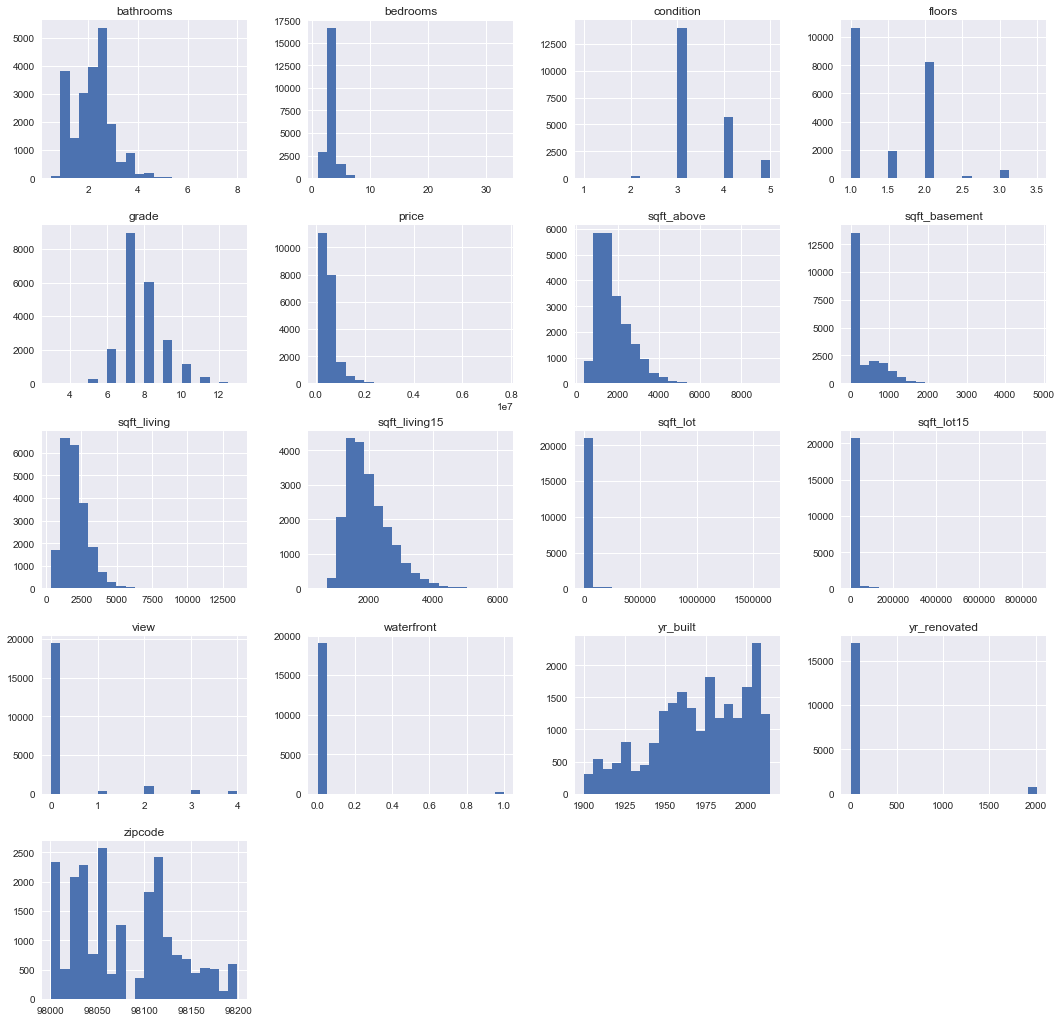

In [17]:
#Last check for numerical vs. categorical variables. Plot histograms

import warnings
warnings.filterwarnings('ignore') #ignore warning message

fig = plt.figure(figsize=(18,18))
ax = fig.gca()
df.hist(ax=ax, bins = 20)
plt.show()

#numerical variables are mostly positively skewed, with the exception of zipcode and yr_built

## Check for Multicollinarity before binning and one-hot encoding
* Plan to bin yr_renovated, waterfront, sqft_basement
    * Coarse classification for yr_renovated, sqft_basement
* One-hot encoding for condition, grade, view

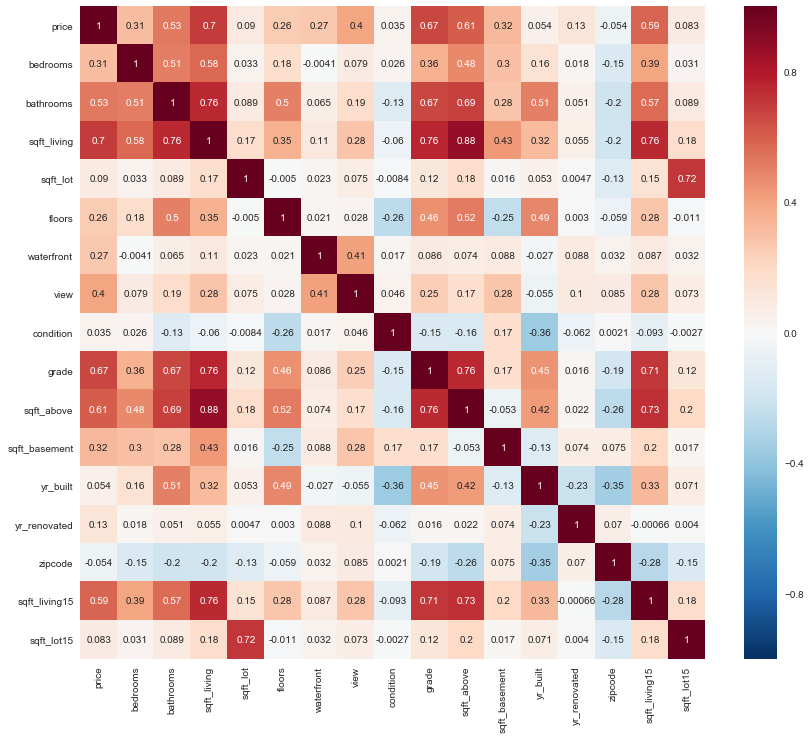

In [18]:
#create heatmap to drop correlated values, especially sqft variables
correlation = df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
#Price seems highly correlated with sqft_living, grade
#Sqft_living highly correlated with sqft_living15, sqft_above, bathrooms, grade
#sqft_lot correlated with sqft_lot15
#Drop: sqft_living15, sqft_lot15, sqft_above

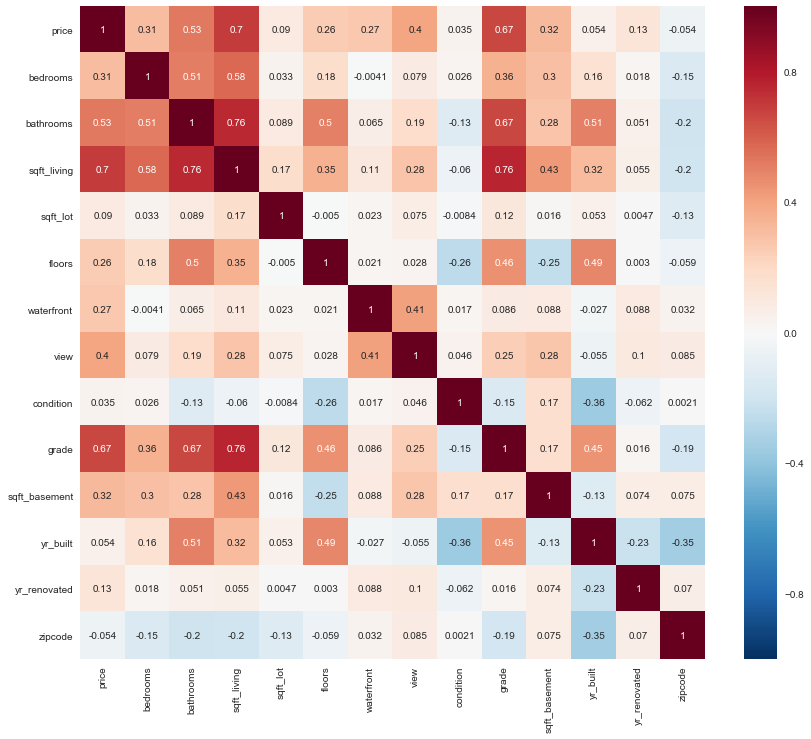

In [19]:
df = df.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis = 1)

#Check heatmap after dropping columns
correlation = df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
#sqft_living is still highly correlated with bathrooms and grade
#since bathrooms and grade are not as highly correlated, drop sqft_living

df = df.drop(['sqft_living'], axis = 1)

## Coarse Classification for Nulls
* Bin yr_renovated, waterfront, sqft_basement

In [20]:
df.isna().sum(0)

date                0
price               0
bedrooms            0
bathrooms           0
sqft_lot            0
floors              0
waterfront       2370
view                0
condition           0
grade               0
sqft_basement     452
yr_built            0
yr_renovated     3830
zipcode             0
dtype: int64

In [21]:
df.yr_renovated.value_counts(dropna = False).sort_index() #Do 0.0 need to be converted to NaNs (16861 0.0 and 3830 NaN)
#There is the possibility that 0.0 means something different from Nan (ex. never renovated vs. unknown)
#Bin houses in the 0.0 category 

 0.0       16961
 1934.0        1
 1940.0        2
 1944.0        1
 1945.0        3
 1946.0        1
 1948.0        1
 1950.0        1
 1951.0        1
 1953.0        1
 1954.0        1
 1955.0        3
 1956.0        3
 1957.0        2
 1958.0        3
 1959.0        1
 1960.0        3
 1962.0        2
 1963.0        4
 1964.0        5
 1965.0        4
 1967.0        2
 1968.0        7
 1969.0        4
 1970.0        9
 1971.0        1
 1972.0        3
 1973.0        4
 1974.0        2
 1975.0        5
           ...  
 1987.0       14
 1988.0       11
 1989.0       20
 1990.0       22
 1991.0       16
 1992.0       13
 1993.0       12
 1994.0       14
 1995.0       11
 1996.0       11
 1997.0       12
 1998.0       16
 1999.0       15
 2000.0       29
 2001.0       15
 2002.0       17
 2003.0       31
 2004.0       22
 2005.0       29
 2006.0       20
 2007.0       30
 2008.0       15
 2009.0       21
 2010.0       15
 2011.0        9
 2012.0        8
 2013.0       31
 2014.0       

In [22]:
df.sqft_basement.value_counts().sort_index()

0.0       12798
10.0          2
20.0          1
40.0          4
50.0         11
60.0         10
65.0          1
70.0          6
80.0         20
90.0         21
100.0        42
110.0        18
120.0        53
130.0        25
140.0        53
143.0         1
145.0         5
150.0        44
160.0        29
170.0        28
172.0         1
176.0         1
180.0        38
190.0        33
200.0       105
207.0         1
210.0        26
220.0        43
225.0         1
230.0        11
          ...  
2170.0        3
2190.0        1
2196.0        1
2200.0        2
2220.0        3
2240.0        1
2250.0        1
2300.0        1
2310.0        1
2330.0        2
2350.0        1
2360.0        1
2400.0        1
2490.0        1
2500.0        1
2550.0        2
2570.0        1
2580.0        1
2600.0        1
2610.0        1
2720.0        1
2730.0        1
2810.0        1
2850.0        1
3000.0        1
3260.0        1
3480.0        1
3500.0        1
4130.0        1
4820.0        1
Name: sqft_basement, Len

In [23]:
#Binning: Create separate bin for NaNs in yr_renovated, waterfront, sqft_basement

df.waterfront.describe()
#Waterfront bins: 0.0, 1.0, NaNs
#df.waterfront = df.waterfront.astype('float')
bins = [0.0, 0.9, 1.1] 
labels = ['0.0', '1.0']
df['waterfront_bins'] = pd.cut(df['waterfront'], bins=bins, labels=labels, include_lowest=True)
df.head()

df.waterfront_bins.replace(np.nan, "NaN", inplace = True, regex = True)
df.waterfront_bins.value_counts()

0.0    19019
NaN     2370
1.0      145
Name: waterfront_bins, dtype: int64

In [24]:
df.yr_renovated.describe()
#yr_renovated bins: 0.0, NaNs, 2015 max, 1934 min (from sorting index on value counts)

bins = [0.0, 1934, 1990, 2005, 2015] 
labels = ['0.0-1934', '1934-1990', '1990-2005', '2005-2015']
df['yr_renovated_bins'] = pd.cut(df['yr_renovated'], bins=bins, labels=labels, include_lowest=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,waterfront_bins,yr_renovated_bins
0,2014-10-13,221900.0,3,1.00,5650,1.0,NaN,0,3,7,0.0,1955,0.0,98178,NaN,0.0-1934
1,2014-12-09,538000.0,3,2.25,7242,2.0,0.0,0,3,7,400.0,1951,1991.0,98125,0.0,1990-2005
2,2015-02-25,180000.0,2,1.00,10000,1.0,0.0,0,3,6,0.0,1933,NaN,98028,0.0,NaN
3,2014-12-09,604000.0,4,3.00,5000,1.0,0.0,0,5,7,910.0,1965,0.0,98136,0.0,0.0-1934
4,2015-02-18,510000.0,3,2.00,8080,1.0,0.0,0,3,8,0.0,1987,0.0,98074,0.0,0.0-1934


In [25]:
df.yr_renovated_bins.replace(np.nan, "NaN", inplace = True, regex = True)
df.yr_renovated_bins.value_counts()

0.0-1934     16962
NaN           3830
1990-2005      263
1934-1990      243
2005-2015      236
Name: yr_renovated_bins, dtype: int64

In [26]:
df.sqft_basement.describe()
#sqft_basement: 0.0, NaNs, 4820 max, 560 75th percentile, 10 min (from sorting index on value counts)

count    21082.000000
mean       291.359975
std        442.007858
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64

In [27]:
bins = [0.0, 1.0, 560, 900, 4821] 
labels = ['0.0-1.0', '1.0-560', '560-900', '900-4821']
df['sqft_basement_bins'] = pd.cut(df['sqft_basement'], bins=bins, labels=labels, include_lowest=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins
0,2014-10-13,221900.0,3,1.00,5650,1.0,NaN,0,3,7,0.0,1955,0.0,98178,NaN,0.0-1934,0.0-1.0
1,2014-12-09,538000.0,3,2.25,7242,2.0,0.0,0,3,7,400.0,1951,1991.0,98125,0.0,1990-2005,1.0-560
2,2015-02-25,180000.0,2,1.00,10000,1.0,0.0,0,3,6,0.0,1933,NaN,98028,0.0,NaN,0.0-1.0
3,2014-12-09,604000.0,4,3.00,5000,1.0,0.0,0,5,7,910.0,1965,0.0,98136,0.0,0.0-1934,900-4821
4,2015-02-18,510000.0,3,2.00,8080,1.0,0.0,0,3,8,0.0,1987,0.0,98074,0.0,0.0-1934,0.0-1.0


In [28]:
df.sqft_basement_bins.replace(np.nan, "NaN", inplace = True, regex = True)
df.sqft_basement_bins.value_counts()

0.0-1.0     12798
1.0-560      3036
560-900      2751
900-4821     2497
NaN           452
Name: sqft_basement_bins, dtype: int64

In [29]:
df.head()
#drop waterfront, sqft_basement, yr_renovated
scrub_df = df.drop(['waterfront', 'sqft_basement','yr_renovated'], axis = 1)
scrub_df.head()

,date,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,yr_built,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins
0,2014-10-13,221900.0,3,1.00,5650,1.0,0,3,7,1955,98178,NaN,0.0-1934,0.0-1.0
1,2014-12-09,538000.0,3,2.25,7242,2.0,0,3,7,1951,98125,0.0,1990-2005,1.0-560
2,2015-02-25,180000.0,2,1.00,10000,1.0,0,3,6,1933,98028,0.0,NaN,0.0-1.0
3,2014-12-09,604000.0,4,3.00,5000,1.0,0,5,7,1965,98136,0.0,0.0-1934,900-4821
4,2015-02-18,510000.0,3,2.00,8080,1.0,0,3,8,1987,98074,0.0,0.0-1934,0.0-1.0


## Normalizing Data
* Normalize int and float columns
    * Will not normalize zipcode, as it is technically categorical 
    * How to handle date and yr_built??** 
    * Normalization will include: price, bedrooms, bathrooms, sqft_lot, floors, date, yr_built
    * Waterfront, sqft_basement, and yr_renovated are categories now
    * View, condition, and grade will be one-hot encoded as categorical

** Plan to subtract date/yr_built from current date to work with a better measure of "time since ___."

As our goal is to predict house price with normalized data, it might be more effective to work with "time since" rather than year. 

In [30]:
#create new time_since variables
import datetime as dt

#create timestamp column of current time - will update whenever code is rerun
scrub_df['timestamp'] = dt.datetime.now()

#convert yr_built to datetime data type
scrub_df['yr_built'] = pd.to_datetime(scrub_df['yr_built'], format='%Y')

#creating two new variables with unit of days since ____
scrub_df['since_sold'] = (scrub_df.timestamp - scrub_df.date).dt.days
scrub_df['since_built'] = (scrub_df.timestamp - scrub_df.yr_built).dt.days

scrub_df.drop(['date','yr_built', 'timestamp'], axis = 1, inplace = True)
scrub_df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,since_sold,since_built
0,221900.0,3,1.00,5650,1.0,0,3,7,98178,NaN,0.0-1934,0.0-1.0,1603,23438
1,538000.0,3,2.25,7242,2.0,0,3,7,98125,0.0,1990-2005,1.0-560,1546,24899
2,180000.0,2,1.00,10000,1.0,0,3,6,98028,0.0,NaN,0.0-1.0,1468,31473
3,604000.0,4,3.00,5000,1.0,0,5,7,98136,0.0,0.0-1934,900-4821,1546,19785
4,510000.0,3,2.00,8080,1.0,0,3,8,98074,0.0,0.0-1934,0.0-1.0,1475,11750


In [31]:
#add since_sold to df1 dataframe use scrub_df for normalized values
#Using a copy of df to preserve original df information before log transformation
df1 = df
df1[['since_sold','since_built']] = scrub_df[['since_sold','since_built']]
df1.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'waterfront_bins', 'yr_renovated_bins',
       'sqft_basement_bins', 'since_sold', 'since_built'],
      dtype='object')

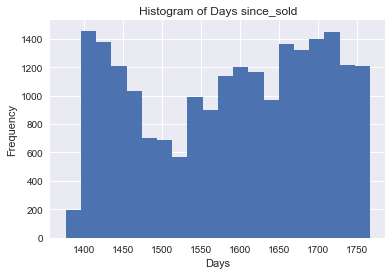

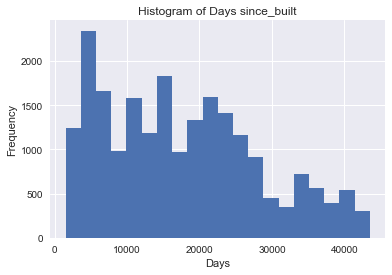

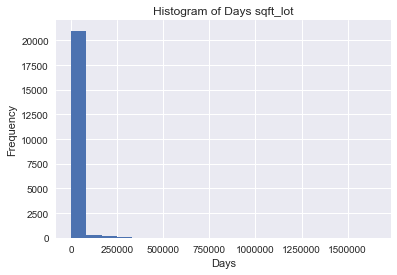

In [32]:
#Check distributions of new columns
for col in ['since_sold', 'since_built', 'sqft_lot']:
    scrub_df[col].hist(bins = 20)
    plt.title('Histogram of Days ' + str(col))
    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.show()

#since_sold is not very normally distributed. since_built is positively skewed- log transforming time!
#added sqft_lot into loop to view it closer- hard to tell it was positively skewed earlier

In [33]:
scrub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 14 columns):
price                 21534 non-null float64
bedrooms              21534 non-null int64
bathrooms             21534 non-null float64
sqft_lot              21534 non-null int64
floors                21534 non-null float64
view                  21534 non-null int32
condition             21534 non-null int64
grade                 21534 non-null int64
zipcode               21534 non-null int64
waterfront_bins       21534 non-null object
yr_renovated_bins     21534 non-null object
sqft_basement_bins    21534 non-null object
since_sold            21534 non-null int64
since_built           21534 non-null int64
dtypes: float64(3), int32(1), int64(7), object(3)
memory usage: 2.4+ MB


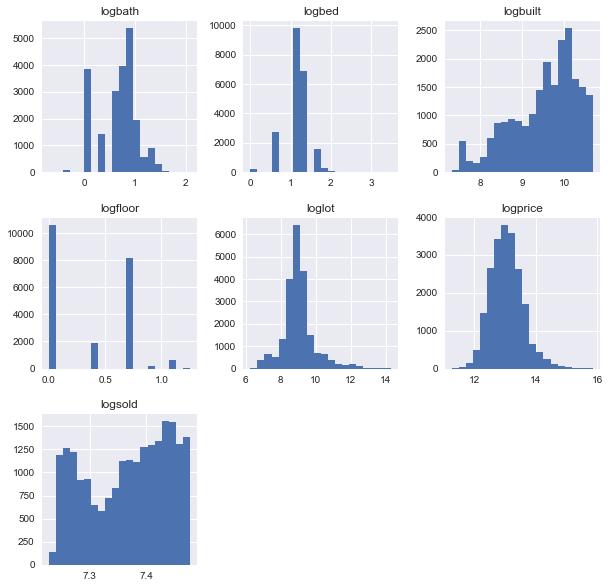

In [34]:
#log transform if positively skewed: bathrooms, bedrooms, floors, price, sqft_lot, since_sold, since_built
#since_sold was not really positively skewed- but log and visualize to check if it would help
data_log = pd.DataFrame([])
data_log['logbath'] = np.log(scrub_df['bathrooms'])
data_log['logbed'] = np.log(scrub_df['bedrooms'])
data_log['logfloor'] = np.log(scrub_df['floors'])
data_log['logprice'] = np.log(scrub_df['price'])
data_log['loglot'] = np.log(scrub_df['sqft_lot'])
data_log['logsold'] = np.log(scrub_df['since_sold'])
data_log['logbuilt'] = np.log(scrub_df['since_built'])

warnings.filterwarnings('ignore')

fig = plt.figure(figsize = (10,10))
ax = fig.gca()
data_log.hist(ax=ax, bins = 20)
plt.show()

#did not help normalize floors, since_sold, or since_built very much- use original variable from scrub_df
#Note that these three variables are not normally distributed, which may affect quality of data analysis

In [35]:
#Normalization will include: price, bedrooms, bathrooms, sqft_lot, floors, since_sold, since_built

price = data_log.logprice
bed = data_log.logbed
bath = data_log.logbath
lot = data_log.loglot
floor = scrub_df.floors
sold = scrub_df.since_sold
built = scrub_df.since_built

scrub_df.price = (price-np.mean(price))/np.sqrt(np.var(price))
scrub_df.bedrooms = (bed-np.mean(bed))/np.sqrt(np.var(bed))
scrub_df.bathrooms = (bath-np.mean(bath))/np.sqrt(np.var(bath))
scrub_df.sqft_lot = (lot-np.mean(lot))/np.sqrt(np.var(lot))
scrub_df.floors = (floor-np.mean(floor))/np.sqrt(np.var(floor))
scrub_df['since_sold'] = (sold-np.mean(sold))/np.sqrt(np.var(sold)) #would not edit these Series without [''] formatting
scrub_df['since_built'] = (built-np.mean(built))/np.sqrt(np.var(built))

In [36]:
scrub_df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,since_sold,since_built
0,-1.402367,-0.279412,-1.726517,-0.388120,-0.915398,0,3,7,98178,NaN,0.0-1934,0.0-1.0,0.142211,0.544764
1,0.280402,-0.279412,0.339761,-0.112983,0.937163,0,3,7,98125,0.0,1990-2005,1.0-560,-0.361935,0.680932
2,-1.799996,-1.710919,-1.726517,0.244666,-0.915398,0,3,6,98028,0.0,NaN,0.0-1.0,-1.051818,1.293644
3,0.500270,0.736259,1.072785,-0.523579,-0.915398,0,5,7,98136,0.0,0.0-1934,900-4821,-0.361935,0.204296
4,0.178847,-0.279412,0.039646,0.008375,-0.915398,0,3,8,98074,0.0,0.0-1934,0.0-1.0,-0.989905,-0.544585


## One-hot Encoding 
* For categorical variables condition, grade, view
* Label encoding for zipcode, then one-hot encoding

In [37]:
#One-hot encoding for condition, grade, view 

cond_dummies = pd.get_dummies(scrub_df.condition, prefix='cond')
grade_dummies = pd.get_dummies(scrub_df.grade, prefix='grade')
view_dummies = pd.get_dummies(scrub_df.view, prefix='view')

scrub_df = pd.concat([scrub_df, cond_dummies, grade_dummies, view_dummies], axis = 1)
scrub_df.drop(['condition','grade','view'], axis = 1, inplace = True)
scrub_df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,since_sold,...,grade_9,grade_10,grade_11,grade_12,grade_13,view_0,view_1,view_2,view_3,view_4
0,-1.402367,-0.279412,-1.726517,-0.388120,-0.915398,98178,NaN,0.0-1934,0.0-1.0,0.142211,...,0,0,0,0,0,1,0,0,0,0
1,0.280402,-0.279412,0.339761,-0.112983,0.937163,98125,0.0,1990-2005,1.0-560,-0.361935,...,0,0,0,0,0,1,0,0,0,0
2,-1.799996,-1.710919,-1.726517,0.244666,-0.915398,98028,0.0,NaN,0.0-1.0,-1.051818,...,0,0,0,0,0,1,0,0,0,0
3,0.500270,0.736259,1.072785,-0.523579,-0.915398,98136,0.0,0.0-1934,900-4821,-0.361935,...,0,0,0,0,0,1,0,0,0,0
4,0.178847,-0.279412,0.039646,0.008375,-0.915398,98074,0.0,0.0-1934,0.0-1.0,-0.989905,...,0,0,0,0,0,1,0,0,0,0


## Create separate dataframes 
One for categorical variables, one for floats and integers. Helps keep things organized.

Set up y variable as target, 'price', in preparation for regression analysis.

In [38]:
#Checking columns
scrub_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'zipcode',
       'waterfront_bins', 'yr_renovated_bins', 'sqft_basement_bins',
       'since_sold', 'since_built', 'cond_1', 'cond_2', 'cond_3', 'cond_4',
       'cond_5', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'view_0', 'view_1', 'view_2', 'view_3', 'view_4'],
      dtype='object')

In [39]:
cat_df = pd.concat([scrub_df.iloc[:,5:9], scrub_df.iloc[:,11:100]], axis =1)
cat_df.head()

,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,cond_1,cond_2,cond_3,cond_4,cond_5,grade_3,...,grade_9,grade_10,grade_11,grade_12,grade_13,view_0,view_1,view_2,view_3,view_4
0,98178,NaN,0.0-1934,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,98125,0.0,1990-2005,1.0-560,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,98028,0.0,NaN,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,98136,0.0,0.0-1934,900-4821,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,98074,0.0,0.0-1934,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [40]:
num_df = pd.concat([scrub_df.iloc[:,1:5], scrub_df.iloc[:,9:11]], axis = 1)
num_df.head()

,bedrooms,bathrooms,sqft_lot,floors,since_sold,since_built
0,-0.279412,-1.726517,-0.388120,-0.915398,0.142211,0.544764
1,-0.279412,0.339761,-0.112983,0.937163,-0.361935,0.680932
2,-1.710919,-1.726517,0.244666,-0.915398,-1.051818,1.293644
3,0.736259,1.072785,-0.523579,-0.915398,-0.361935,0.204296
4,-0.279412,0.039646,0.008375,-0.915398,-0.989905,-0.544585


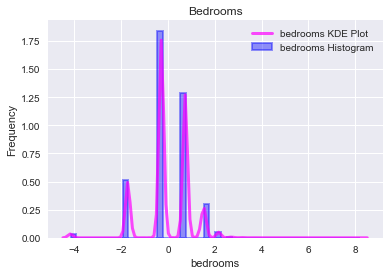

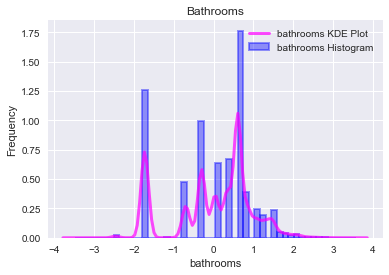

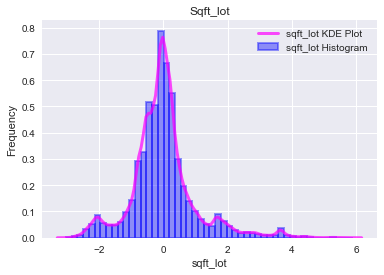

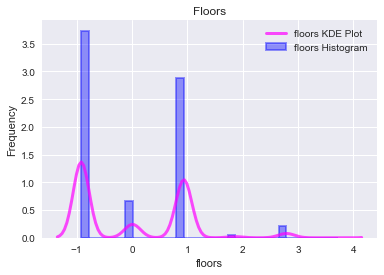

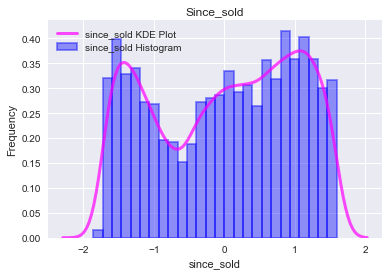

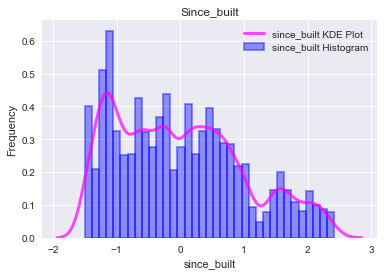

In [41]:
#kde and histograms of num variables
#Using kde, which is non-parametric way of visualizing underlying distribution (probability density function)
#Allows for more detailed information on distribution as compared to the histogram, which is more discrete.
#Helps better answer the question: Is the data normally distributed?
for col in list(num_df.columns):
    sns.distplot(num_df[col], 
                 hist=True, hist_kws={
                                      "linewidth": 2,
                                      'facecolor': 'b',
                                      "edgecolor" :'b',
                                      "alpha": 0.4, 
                                      "color":  "w",
                                      "label": col + " Histogram",
                                      },
                 kde=True, kde_kws = {'linewidth': 3,
                                      'color': "magenta",
                                      "alpha": 0.7,
                                      'label':col + ' KDE Plot'
                                     })

    plt.title(col.capitalize())
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
#Need some help plotting these hist/kdes in a 2x3 array

In [42]:
y = scrub_df['price']

## Questions to Investigate
Overall question for regression: Which variables should be used to form a model which best predicts price?

1. Do more recent renovations improve housing price?
2. Are houses with the same number of grade more expensive when sold recently vs. a long time ago? 
3. Is there a significant difference in price depending on number of bathrooms?

Reasoning for question 1: 
Would like to investigate a categorical variable, especially after data cleaning and scrubbing, to see if it now shows any correlation with price. The initial correlation heatmap showed very little correlation between yr_renovated and price. From a business perspective, it would be helpful to know whether an investment of renovation would increase house price or not, in order to predict when to renovate a house. Would last minute renovations before selling improve price?

Reasoning for question 2: 
Investigating a numerical variable. If the answer to this question is yes and high correlation is found between recent purchases and price, then it might help a company better decide when to invest in flipping houses and when to invest in multiple properties to for appreciation in house value. Using grade as a control when comparing, since it seems to be moderately correlated with price upon checking the correlation heatmap.
* Depending on how data was collected, price may be price of house when last sold, rather than current price. Usually governments keep track of house value for for taxing purposes, but cannot be certain that these prices reflect current value. 

Reasoning for question 3: 
Bathrooms was moderately correlated with price on heatmap. Answering this question could help businesses decide whether renovating a house by adding a bathroom might allow them to sell it for more. 


## Question 1: Do more recent renovations improve housing price?

In [43]:
cat_df.yr_renovated_bins.value_counts()

0.0-1934     16962
NaN           3830
1990-2005      263
1934-1990      243
2005-2015      236
Name: yr_renovated_bins, dtype: int64

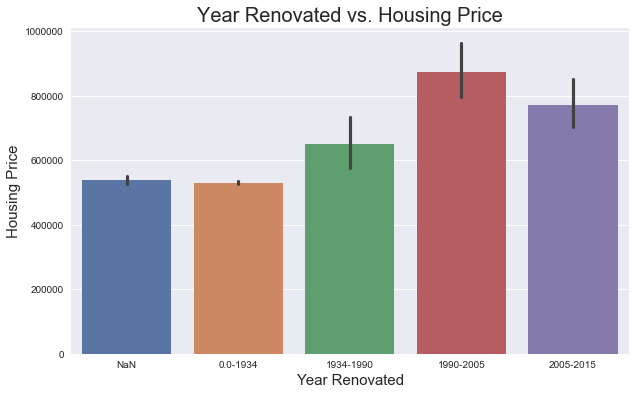

In [44]:
#Using sns to explore their visualizations. 
#Had much less exposure to sns visualizations compared to matplotlib over the first module
ax = plt.figure(figsize = (10,6))
ax = sns.barplot(x = 'yr_renovated_bins', y = 'price', data = df, order = ['NaN', '0.0-1934', '1934-1990', '1990-2005', '2005-2015'], palette = 'deep')
ax.set_ylabel('Housing Price', fontsize = 15)
ax.set_xlabel('Year Renovated', fontsize = 15)
ax.set_title('Year Renovated vs. Housing Price', fontsize = 20)
plt.show()

I decided to compare bins vs. the original data for housing price, before it was normalized, as it is difficult to understand the scale when using the normalized variable. The NaN and 0.0-1934 categories are fairly similar, with comparatively minimal standard deviation and a mean around $550000. 

`There is a standard deviation of approximately $180000, $170000, and $160000 for the categories 1934-1990, 1990-2005, and 2005-2015, respectvely. The average housing price is approximately $650000, $875000, and $790000, respectively. `

It does seem that renovations improve housing price, as we can see a general trend of increasing average price when comparing the houses renovated between 1934-1990 and those renovated between 1990-2005. However, the average prices of houses renovated between 2005-2015 do not reflect this trend. This implies that more recent renovations may not always correlate to a higher housing price. There could be various explanations for this, including the possibility that the housing market was affected by the 2008 crisis: https://fred.stlouisfed.org/series/ASPUS. However, the houses which were renovated between 2005 and 2015 were still sold at higher prices than those renovated between 1934 and 1990. 

The data seems to support the idea that more recent renovations improve housing price. However, stakeholders must continue to monitor the housing market to determine whether to renovate and sell their properties.

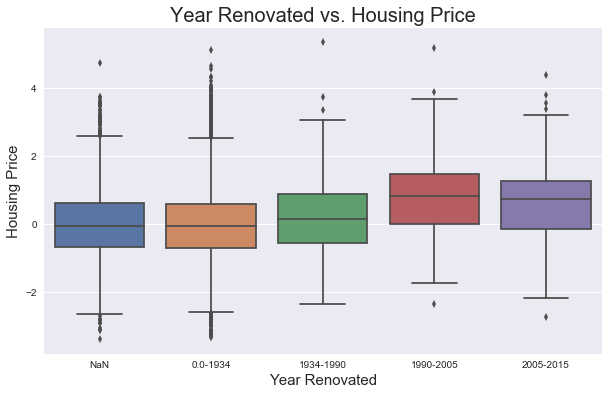

In [45]:
ax = plt.figure(figsize = (10,6))
ax = sns.boxplot(x = 'yr_renovated_bins', y = 'price', data = scrub_df, order = ['NaN', '0.0-1934', '1934-1990', '1990-2005', '2005-2015'], palette = 'deep')
ax.set_ylabel('Housing Price', fontsize = 15)
ax.set_xlabel('Year Renovated', fontsize = 15)
ax.set_title('Year Renovated vs. Housing Price', fontsize = 20)
plt.show()

The boxplot was visualized to check for outliers. The NaN and 0.0-1934 categories seem to have a decent amount of outliers. The 0.0-1934 category actually only includes values which were coded as 0.0 in the original dataset. From this plot, it seems that we can conclude those 0.0 data points were meant to represent NaN values. 

In the next iteration of data processing, we can plan to recode 0.0 as placeholder values when binning the data. It also might be interesting to separate the data into more bins to get a clearer picture of the relationship between year renovated and price. The current bins (1934-1990, 1990-2005, 2005-2015) were separated such that each bin had a similar number of data points. We could plan to split these bins into 4-5 bins instead.

## Question 2: Are houses with the same grade more expensive when sold recently?

In [46]:
##This visualization is okay, but still a bit messy. 
##Scatter seems to be a better, clearer plotting method, as there are some extreme outliers and many data points
#ax1 = sns.lineplot(x=df1.since_sold, y=df1.price, hue = df1.grade, sort=False, lw=1)
#plt.title('Time since sold vs. housing price')
#plt.show()
#
##The color gradient shows a fairly clear relationship between higher grades and price, as expected.
hide_toggle()

In [47]:
##consider plotting less data
##no, plot by grade and not cat plot
#ax2 = sns.catplot(x="since_sold", y="price", hue="grade",
#               palette = 'rainbow', data=df1, kind="swarm")
##my_xticks = ax2.get_xticks()
##ax2.set_xticks([my_xticks[0], my_xticks[-1]], visible=True, rotation="horizontal")
#plt.show()
hide_toggle()

In [48]:
#sns.pairplot(df1, vars = ['since_sold', 'price'], hue = 'grade', palette = 'rainbow', diag_kind = 'kde',
#             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
#             size = 4)
##axes = plt.gca()  # Get current axes
##axes.lines.remove(ax2[0])  # Removes the (first and only) line created in ax2
#plt.draw()  # Updates the graph (in interactive mode)
#plt.show()
#
##num_bathrooms = sorted(df1.bathrooms.value_counts().index.tolist())
##for val in num_bathrooms:
##fig, ax = plt.subplots(1,1, figsize=(10,10))
##df1.groupby("bathrooms").plot(x="since_sold", y="price", ax=ax)
##plt.show()
#
#ax2 = sns.factorplot(data = df1, x = 'since_sold', y = 'price', col= 'bathrooms') 
#plt.show()
hide_toggle()

In [49]:
scrub_df.head()
#dataframe used to provide data for analysis will be scrub_df, with normalized values in since_sold and price variables

,price,bedrooms,bathrooms,sqft_lot,floors,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,since_sold,...,grade_9,grade_10,grade_11,grade_12,grade_13,view_0,view_1,view_2,view_3,view_4
0,-1.402367,-0.279412,-1.726517,-0.388120,-0.915398,98178,NaN,0.0-1934,0.0-1.0,0.142211,...,0,0,0,0,0,1,0,0,0,0
1,0.280402,-0.279412,0.339761,-0.112983,0.937163,98125,0.0,1990-2005,1.0-560,-0.361935,...,0,0,0,0,0,1,0,0,0,0
2,-1.799996,-1.710919,-1.726517,0.244666,-0.915398,98028,0.0,NaN,0.0-1.0,-1.051818,...,0,0,0,0,0,1,0,0,0,0
3,0.500270,0.736259,1.072785,-0.523579,-0.915398,98136,0.0,0.0-1934,900-4821,-0.361935,...,0,0,0,0,0,1,0,0,0,0
4,0.178847,-0.279412,0.039646,0.008375,-0.915398,98074,0.0,0.0-1934,0.0-1.0,-0.989905,...,0,0,0,0,0,1,0,0,0,0


In [50]:
df1.grade.value_counts()
#Note that there is only one data point for grade = 3, which is too small a sample size to use in analysis.
#Plot anyway for completion
#Other grades with minimal data points include houses of grade 13, 4, and possibly 12.

7     8948
8     6053
9     2604
6     2031
10    1130
11     397
5      242
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

In [51]:
#Preparation to plot regplot between since_sold and price, which will visualize regression line and confidence interval
#separate dataframe into separate dataframes, one for each grade
#use loc to separate by grade = ?
grade_dfs = []
grades = list(df1.grade.value_counts().index)
grades.sort()
for num in grades:
    name_of_df = 'df_'+str(num) 
    name_of_df = scrub_df.loc[scrub_df['grade_'+str(num)] == True]
    grade_dfs.append(name_of_df)

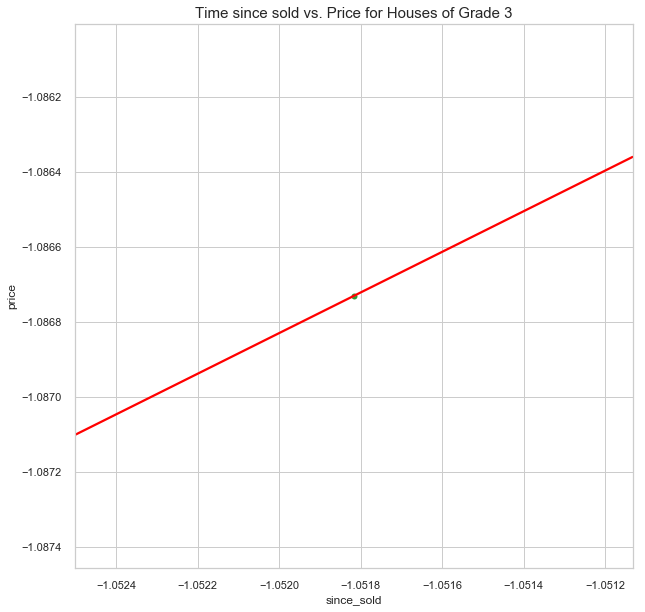

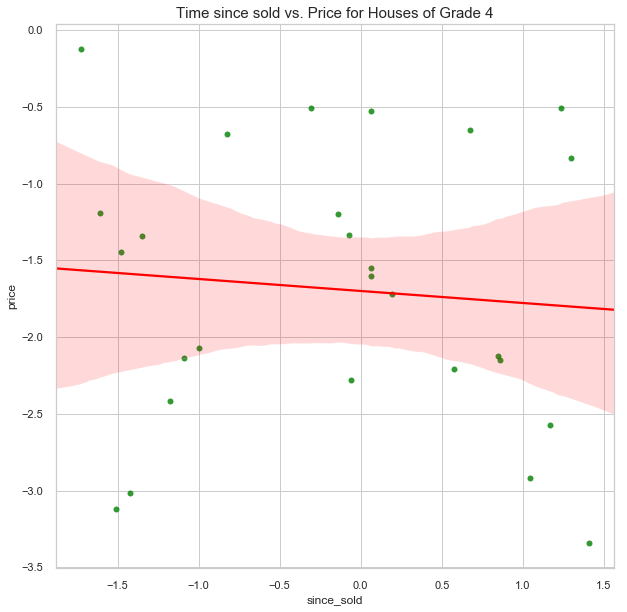

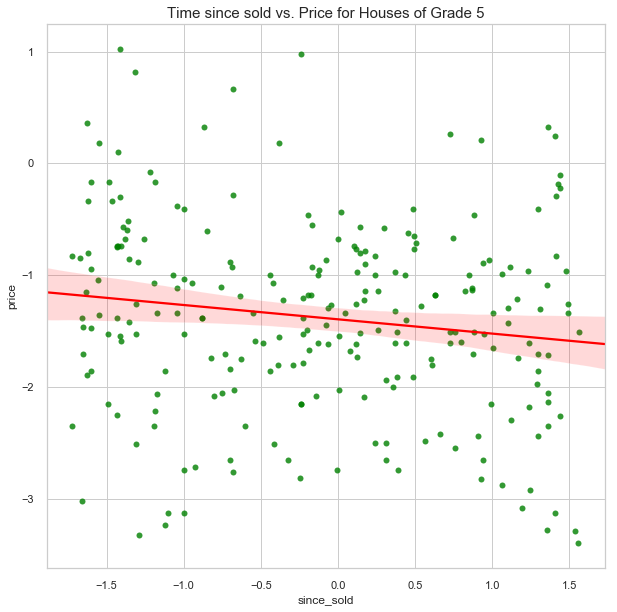

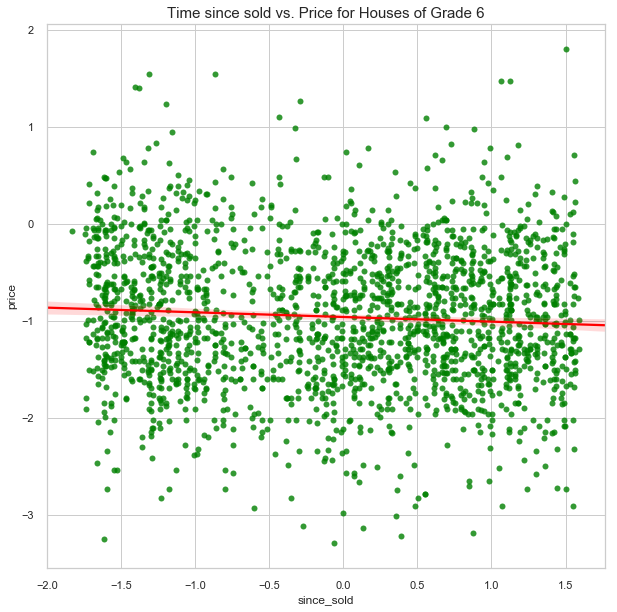

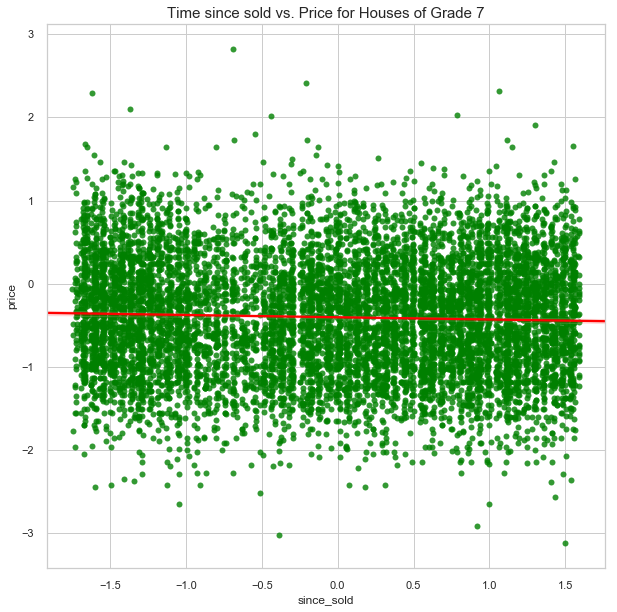

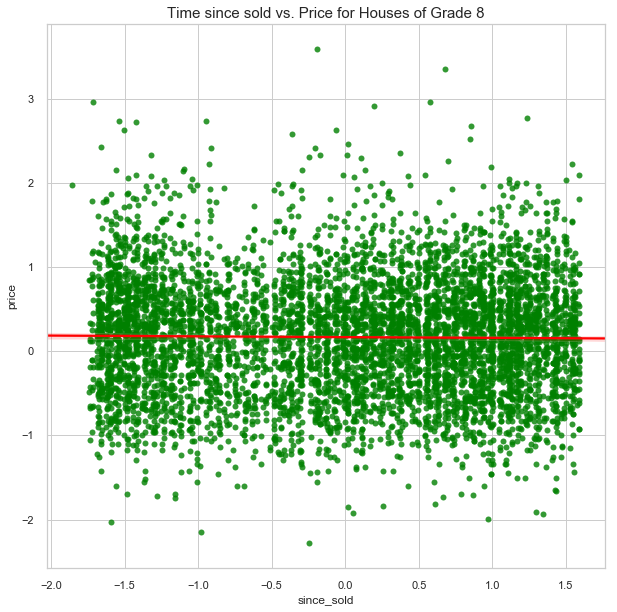

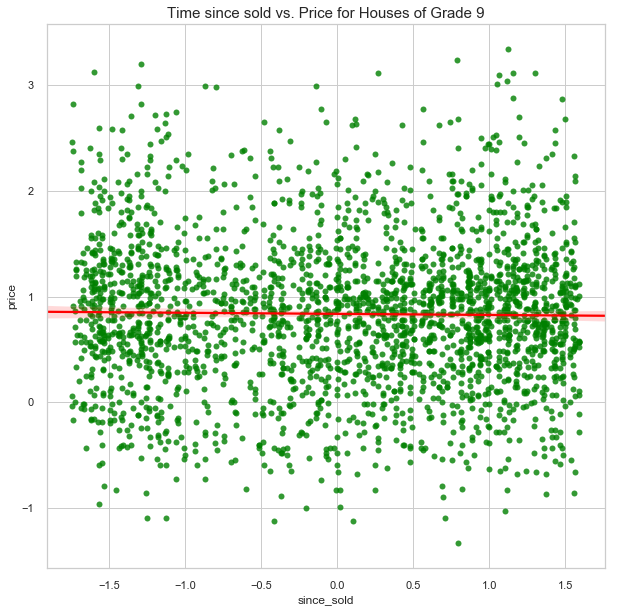

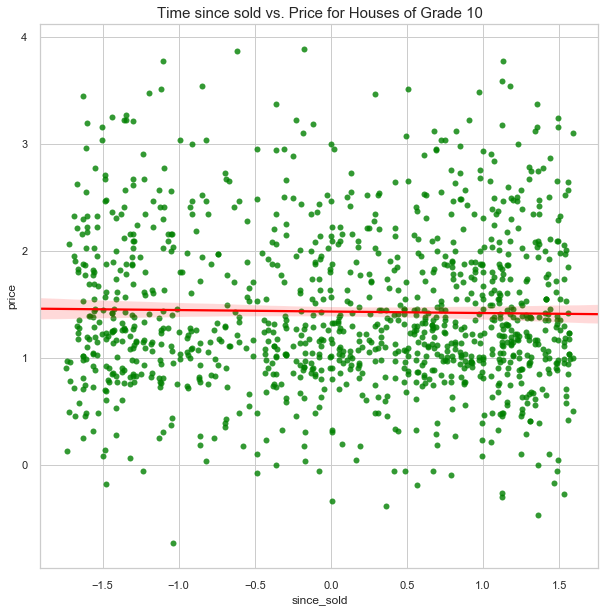

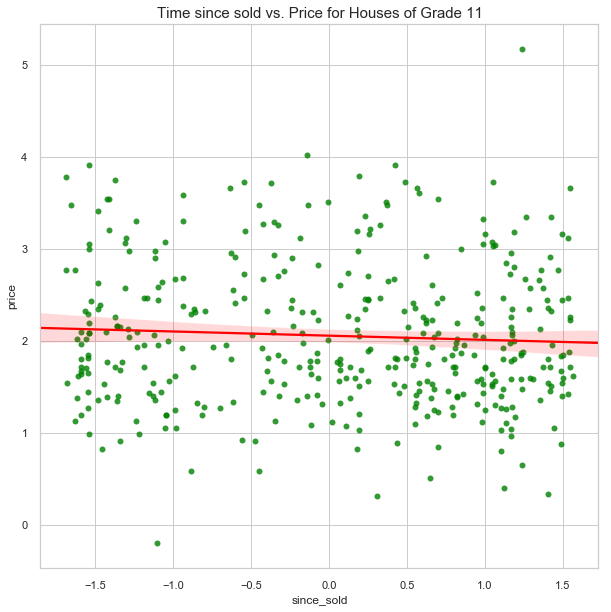

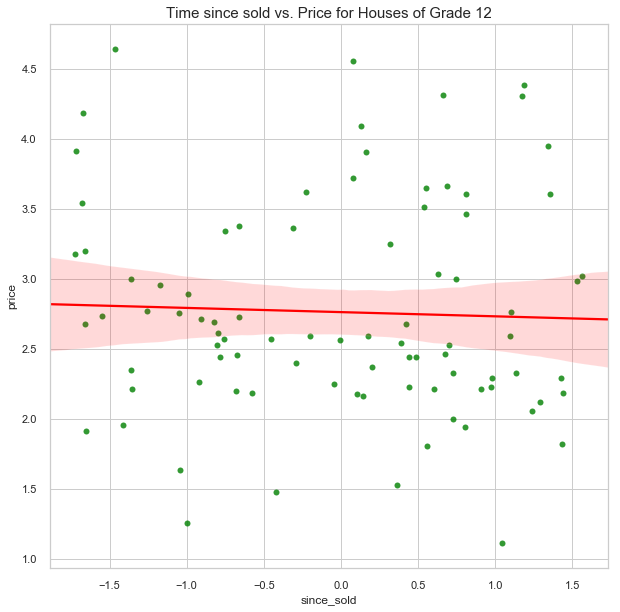

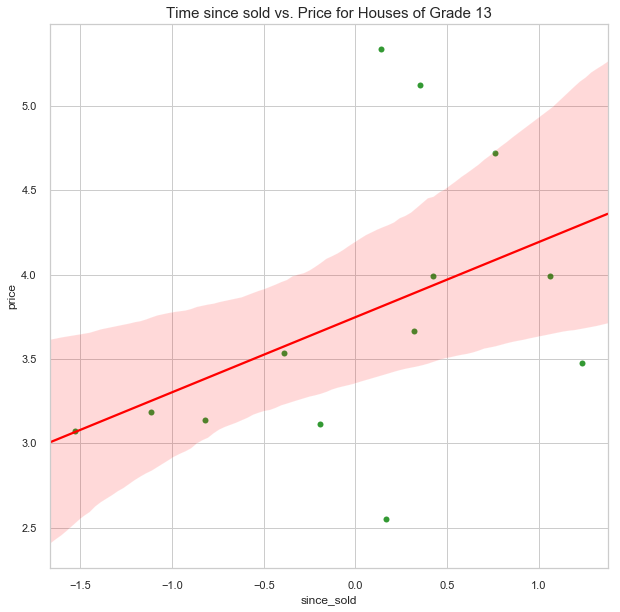

In [52]:
#grade_dfs is list which holds a dataframe for each grade
#Plotting regplot between since_sold and price for each grade by iterating through grade_dfs

sns.set(style="whitegrid")

for i in range(0 , len(grade_dfs)):
    f, axs = plt.subplots(figsize = (10,10))
    sns.regplot(x='since_sold', y="price", data=grade_dfs[i], scatter_kws={"color": "green"}, line_kws={"color": "red"})
    plt.title('Time since sold vs. Price for Houses of Grade ' +str(i+3), fontsize = 15)
    plt.show()
#find a way to store r values and slope

`From the regplot of since sold vs. price, divided into grade bins, there seems to be a general trend of lower price when it has been longer since the house was sold.` This cannot be strongly inferred with houses of grade 3, 4, and 12. Grades 3 and 4 have low bin sizes, 1 and 27 data points, respectively. Grade 12 also had a somewhat lower bin size of 88 data points. The results of grade 3 should simply be excluded from data analysis. There may have not been a large enough sample size to catch a strong correlative relationship with houses of grade 4 or 12. For both grades 4 and 12, there is a slightly negative correlation found from the seaborn regplot regression. However, the confidence interval band (95%) is extremely wide, with an hourglass shape on the edges. 

`Houses of grades 5, 6, 7, 8, 9, 10, and 11 seem to have higher prices when sold recently, and lower prices when sold a longer time ago (negative correlation between time since sold and price).` This does seem to make logical sense, as their value continues appreciating with time, as would be expected from houses in the housing market where the general trend is appreciation of price over time. This analysis assumes the price variable is reflective of the market value when the house was sold, which may not always be the case depending on the circumstances of the sale. However, the sheer amount of housing data used to generate the conclusion should account for the exceptions, as houses of grades 6-10 had a number of data points ranging from 1000+ to approximately 8900.

Houses of grade 13 actually seem to have a positive correlation between time since sold and price (they are more expensive the longer since they were sold), which is opposite the general trend seen in the rest of the data. This may be because there are only 13 data points in that bin. 
From the correlation heatmap plotted earlier in analysis, it seems that grade is highly correlated with sqft variables and bathrooms. Therefore, it would be reasonable to assume that the houses of grade 13 are mansions, which are usually built with large sqft and many rooms. 
The positive correlation may indicate that these houses actually tend to depreciate over time (lower price when sold recently), and are initially sold for a very high price (the y axis range goes over 5.0, which is not seen in graphs of lower grades).
Due to the low amount of data, this conclusion is tentative. However, the preliminary results could be used to warn real estate companies or the extremely wealthy from investing in houses of this grade.

## Question 3: Is there a significant difference in price depending on number of bathrooms?

In [53]:
df1.bathrooms.value_counts()
#Eliminate categories with few data points: 5.25 to 8.00, 0.50, 1.25

2.50    5364
1.00    3841
1.75    3035
2.25    2037
2.00    1926
1.50    1441
2.75    1185
3.00     752
3.50     730
3.25     585
3.75     155
4.00     136
4.50     100
4.25      77
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       5
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [54]:
#Eliminate categories with few data points: 5.25 to 8.00, 0.50, 1.25
df3 = df1[(df1.bathrooms < 5.25) & (df1.bathrooms != 0.50) & (df1.bathrooms != 1.25)]
df3.bathrooms.value_counts()

2.50    5364
1.00    3841
1.75    3035
2.25    2037
2.00    1926
1.50    1441
2.75    1185
3.00     752
3.50     730
3.25     585
3.75     155
4.00     136
4.50     100
4.25      77
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64

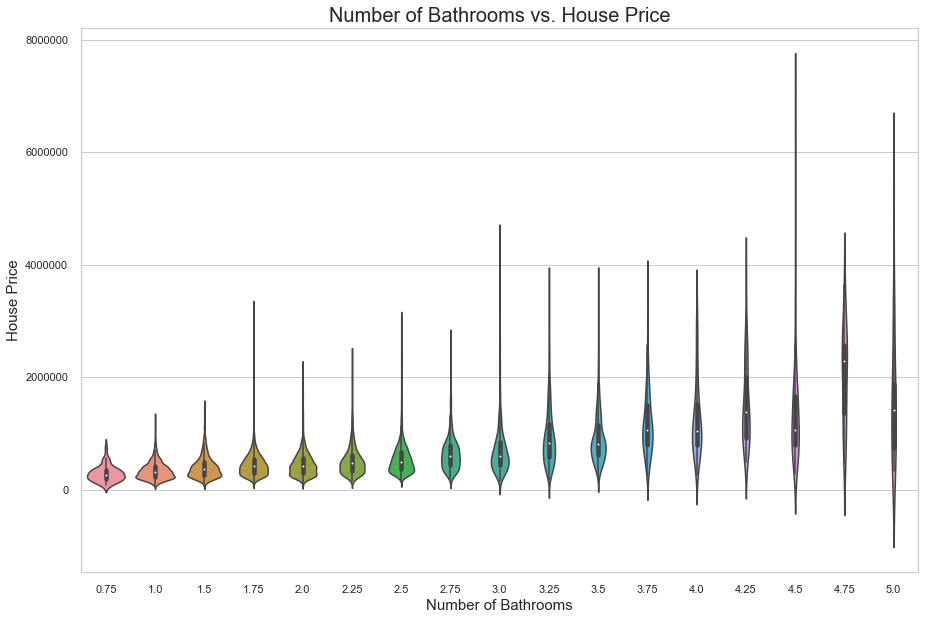

In [55]:
#plotting a categorical variable vs. a continuous variable
#Use df3 data
#Use seaborn violinplot for categorical vs. continuous, where bathrooms = x, price = y
sns.set(style="whitegrid")
fig, ax3 = plt.subplots(figsize = (15,10))
ax3 = sns.violinplot(x="bathrooms", y="price", data=df3)
ax3.set_title('Number of Bathrooms vs. House Price', fontsize = 20)
plt.ticklabel_format(style='plain', axis='y')
ax3.set_ylabel('House Price', fontsize = 15)
ax3.set_xlabel('Number of Bathrooms', fontsize = 15)
plt.show()

25th - 75th quartiles for each category are shown as mini box within the violinplot. The violinplot combines a boxplot with a kernel density estimate of underlying distribution. It seems that the KDE of price within each category is relatively normal, although the KDEs of houses with more bathrooms seem platykurtic, likely reflective of the smaller sample size. No obviously multimodal distributions seen.
There is not enough data in the 4.25, 4.75, and 5.00 categories to draw a strong conclusion (number of data points < 100), so it would be best to look at the plot from 0.75-4.0. Also, it seems strange that the violinplot would extend below zero in some of the categories. This may be due to the smaller sample size- it would be harder to accurately estimate the probability density function with less data to work with, causing the function to include values below zero as possible results. There are no values below zero in the price column (see histograms visualized during data exploration).

`There seems to be a general increase in price with increasing number of bathrooms in a house, up until 5.0 bathrooms.`
The increase in price ranges from approximately `$`250,000 at 0.75 bathrooms to approximately `$`1,000,000 at 4.0 bathrooms. It seems that depending on the situation, adding a bathroom may be able to increase house price. In fact, the mean housing price does increase with the number of bathrooms, even when increasing number of bathrooms by 0.25 increments. However, this conclusion is not definite, as these analyses can only infer correlations, not causations. The more applicable conclusion would be that total number of bathrooms corresponds to an increase in price. Therefore, purchasing a house with even 0.25 more bathrooms overall would correspond with a greater price. 

The dip in price at 5.0 may be simply an artifact of low sample size, or indicative of a larger trend: it is possible that beyond a certain number of bathrooms, there is no longer a corresponding positive increase in the house price. Plot 4.0-7.75 in the next graph to see if we can find an opposite trend (more bathrooms corresponding to decrease in house price). 

In [56]:
df4 = df1[(df1.bathrooms >= 4.0) & (df1.bathrooms <= 7.75)]
df4.bathrooms.value_counts()

4.00    136
4.50    100
4.25     77
4.75     23
5.00     21
5.25     13
5.50     10
6.00      5
5.75      4
6.50      2
6.25      2
6.75      2
7.75      1
7.50      1
Name: bathrooms, dtype: int64

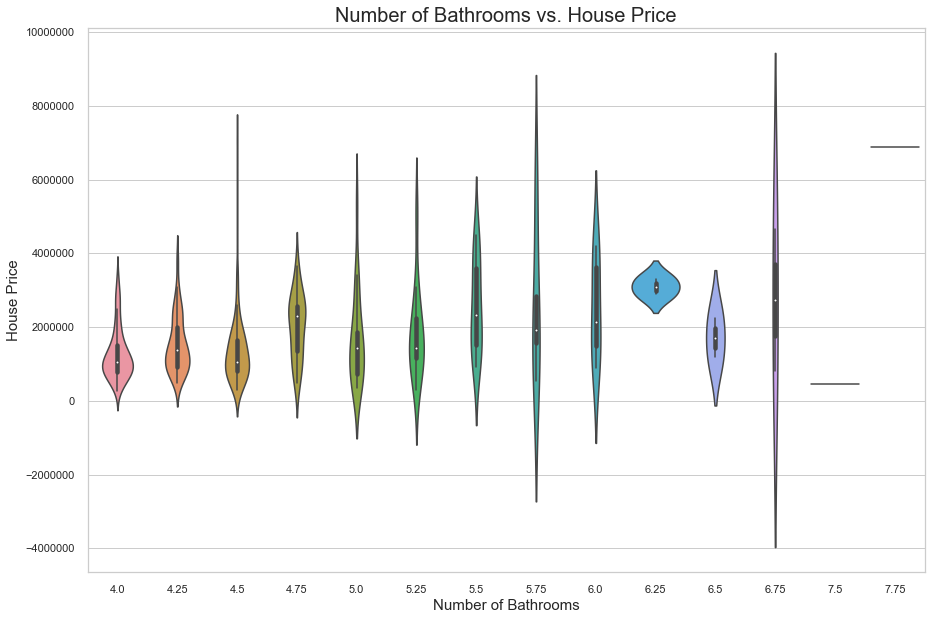

In [57]:
sns.set(style="whitegrid")
fig, ax4 = plt.subplots(figsize = (15,10))
ax4 = sns.violinplot(x="bathrooms", y="price", data=df4)
ax4.set_title('Number of Bathrooms vs. House Price', fontsize = 20)
plt.ticklabel_format(style='plain', axis='y')
ax4.set_ylabel('House Price', fontsize = 15)
ax4.set_xlabel('Number of Bathrooms', fontsize = 15)
plt.show()

There doesn't seem to be a negative correlation between increased number of bathrooms over 5.0. Instead, it seems that the price fluctuates when there are more than 5 bathrooms in the house. However, this finding is tentative at best, due to the small sample size of houses with more than 5 bathrooms.

## Time for Modelling!
* Find which predictors best predict housing price
* Use num_df and cat_df when investigating numerical and categorical variables, respectively
* Feature ranking with feature elimination to choose predictors
* Create a model based on predictors suggested by feature ranking
* Holdout validation

In [58]:
cat_df.head()

,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,cond_1,cond_2,cond_3,cond_4,cond_5,grade_3,...,grade_9,grade_10,grade_11,grade_12,grade_13,view_0,view_1,view_2,view_3,view_4
0,98178,NaN,0.0-1934,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,98125,0.0,1990-2005,1.0-560,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,98028,0.0,NaN,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,98136,0.0,0.0-1934,900-4821,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,98074,0.0,0.0-1934,0.0-1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [59]:
#Use num_df and cat_df for predictors. Drop zipcode from cat_df.
#Use y for target

cat_df = cat_df.drop(['zipcode'], axis = 1)

#dropped one category from each of the dummy variables (Dropped: cond_5, grade_13, view_4.0)
cols_waterfront = cat_df.columns[0:1]
cols_renov = cat_df.columns[1:2]
cols_base = cat_df.columns[2:3]
cols_cond = cat_df.columns[3:7]
cols_grade = cat_df.columns[8:18]
cols_view = cat_df.columns[19:23]

#add target variable y in preparation for modelling
cat_df = pd.concat((cat_df, y.rename('Price')), axis=1)

cols = [cols_waterfront, cols_renov, cols_base, cols_cond, cols_grade, cols_view]
for col in cols:
    sum_cols = '+'.join(col)
    f = 'Price~' + sum_cols
    m = ols(formula = f, data = cat_df, missing = 'drop').fit()
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     632.3
Date:                Mon, 04 Mar 2019   Prob (F-statistic):          2.68e-137
Time:                        16:57:43   Log-Likelihood:                -26913.
No. Observations:               19164   AIC:                         5.383e+04
Df Residuals:                   19162   BIC:                         5.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

R-squared and Adjusted R-squared for categorical variables were as follows:
* waterfront 
    ** r-squared: 0.032, Adj. r-squared: 0.032.
* yr_renovated 
    ** r-squared: 0.017, Adj. r-squared: 0.016
* sqft_basement 
    ** r-squared: 0.089, Adj. r-squared: 0.089
* condition 
    ** r-squared: 0.014, Adj. r-squared: 0.013
* grade 
    ** r-squared: 0.497, Adj. r-squared: 0.497
* view 
    ** r-squared: 0.123, Adj. r-squared: 0.123
    
Based on this analysis, it would be more effective to use grade and view when creating the final model.
All p values are below threshold of 0.05

Would creating dummy variables for waterfront, yr_renovated, and sqft_basement change their r-squared and adj. r_squared values? Checking below:

In [60]:
cat_df["waterfront_bins"] = cat_df["waterfront_bins"].astype('category')
cat_df["yr_renovated_bins"] = cat_df["yr_renovated_bins"].astype('category')
cat_df["sqft_basement_bins"] = cat_df["sqft_basement_bins"].astype('category')

new_df = pd.DataFrame()
new_df["waterfront_bins"] = cat_df["waterfront_bins"].cat.codes
new_df["yr_renovated_bins"] = cat_df["yr_renovated_bins"].cat.codes
new_df["sqft_basement_bins"] = cat_df["sqft_basement_bins"].cat.codes
new_df.head()

,waterfront_bins,yr_renovated_bins,sqft_basement_bins
0,2,0,0
1,0,2,1
2,0,4,0
3,0,0,3
4,0,0,0


In [61]:
water_dummies = pd.get_dummies(new_df.waterfront_bins, prefix = 'water')
yr_renov_dummies = pd.get_dummies(new_df.yr_renovated_bins, prefix='yr_renov')
sqft_base_dummies = pd.get_dummies(new_df.sqft_basement_bins, prefix='sqft_base')

trial_df = pd.concat([yr_renov_dummies, sqft_base_dummies, water_dummies], axis = 1)
trial_df.head()

,yr_renov_0,yr_renov_1,yr_renov_2,yr_renov_3,yr_renov_4,sqft_base_0,sqft_base_1,sqft_base_2,sqft_base_3,sqft_base_4,water_0,water_1,water_2
0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,1,1,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0,1,0,0
4,1,0,0,0,0,1,0,0,0,0,1,0,0


In [62]:
#dropped one category from each of the dummy variables (Dropped: water_2, yr_renovated_4, sqft_basement_4)
cols_waterfront = trial_df.columns[10:12]
cols_renov = trial_df.columns[0:4]
cols_base = trial_df.columns[5:9]

#add target variable y in preparation for modelling
trial_df = pd.concat((trial_df, y.rename('Price')), axis=1)

cols = [cols_waterfront, cols_renov, cols_base]
for col in cols:
    sum_cols = '+'.join(col)
    f = 'Price~' + sum_cols
    m = ols(formula = f, data = trial_df).fit()
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     316.7
Date:                Mon, 04 Mar 2019   Prob (F-statistic):          2.65e-136
Time:                        16:57:43   Log-Likelihood:                -30243.
No. Observations:               21534   AIC:                         6.049e+04
Df Residuals:                   21531   BIC:                         6.052e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0221      0.020     -1.092      0.2

R-squared and Adjusted R-squared for categorical variables which were one-hot encoded were as follows:
* waterfront 
    ** r-squared: 0.029, Adj. r-squared: 0.028.
* yr_renovated 
    ** r-squared: 0.014, Adj. r-squared: 0.013
* sqft_basement 
    ** r-squared: 0.087, Adj. r-squared: 0.087
    
These values are actually slightly lower than the values produced when they were binned, prior to one-hot encoding. Again, not much difference between the r-squared and adj. r-squared values.
p-values of water_0, yr_renov_0, and sqft_base_1 are too high to use for modelling. Try to model again without these variables. Include water_2, yr_renovated_4, and sqft_basement_4 instead.

In [63]:
#dropped one category from each of the dummy variables (Dropped: water_0, yr_renov_0, sqft_base_1)
cols_waterfront = trial_df.columns[11:13]
cols_renov = trial_df.columns[1:5]
cols_base = trial_df.columns[6:10]

cols = [cols_waterfront, cols_renov, cols_base]
for col in cols:
    sum_cols = '+'.join(col)
    f = 'Price~' + sum_cols
    m = ols(formula = f, data = trial_df).fit()
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     316.7
Date:                Mon, 04 Mar 2019   Prob (F-statistic):          2.65e-136
Time:                        16:57:44   Log-Likelihood:                -30243.
No. Observations:               21534   AIC:                         6.049e+04
Df Residuals:                   21531   BIC:                         6.052e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0129      0.007     -1.804      0.0

P values for yr_renov_4, water_2 are too high (>0.05 alpha). Exclude water_0, water_2, yr_renov_0, yr_renov_4, sqft_base_1 from analysis.

Time to check the r-squared values for numerical variables.

In [64]:
num_df.head()

,bedrooms,bathrooms,sqft_lot,floors,since_sold,since_built
0,-0.279412,-1.726517,-0.388120,-0.915398,0.142211,0.544764
1,-0.279412,0.339761,-0.112983,0.937163,-0.361935,0.680932
2,-1.710919,-1.726517,0.244666,-0.915398,-1.051818,1.293644
3,0.736259,1.072785,-0.523579,-0.915398,-0.361935,0.204296
4,-0.279412,0.039646,0.008375,-0.915398,-0.989905,-0.544585


In [65]:
col_names = num_df.describe().columns
#num_df = pd.concat((num_df, y.rename('Price')), axis=1)
results_log = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Kings County Housing: Price~" + val)

    f = 'price~' + val
    model = ols(formula=f, data=num_df).fit()
    X_new = pd.DataFrame({val: [num_df[val].min(), num_df[val].max()]});
    preds = model.predict(X_new)
    results_log.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results_log[idx+1], '\n')

Kings County Housing: Price~bedrooms
['bedrooms', 0.11723101983892992, 13.048039966350839, 0.18019803908208987, 0.0] 

Kings County Housing: Price~bathrooms
['bathrooms', 0.2704867926991904, 13.048039966350839, 0.27371703143147563, 0.0] 

Kings County Housing: Price~sqft_lot
['sqft_lot', 0.019101659377448454, 13.048039966350839, 0.07273849940675248, 2.6170380735875694e-92] 

Kings County Housing: Price~floors
['floors', 0.09640551868742864, 13.048039966350839, 0.16341041649703825, 0.0] 

Kings County Housing: Price~since_sold
['since_sold', 2.2058904946997693e-05, 13.048039966350839, 0.0024718423218196145, 0.4907111522920632] 

Kings County Housing: Price~since_built
['since_built', 0.006544724983033046, 13.048039966350839, -0.042576944357398894, 1.3281656262466274e-32] 



In [66]:
#Check r values of variables which were not log transformed. 
num_df_nolog = df1[['price', 'bedrooms','bathrooms','sqft_lot','floors','since_sold','since_built']].copy()

col_names = num_df_nolog.describe().columns
results_log = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Kings County Housing (No log transformation): Price~" + val)

    f = 'price~' + val
    model = ols(formula=f, data=num_df).fit()
    X_new = pd.DataFrame({val: [num_df_nolog[val].min(), num_df_nolog[val].max()]});
    preds = model.predict(X_new)
    results_log.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results_log[idx+1], '\n')

Kings County Housing (No log transformation): Price~price
['price', 1.0, -2.4868995751603507e-14, 1.000000000000001, 0.0] 

Kings County Housing (No log transformation): Price~bedrooms
['bedrooms', 0.11723101983892992, 13.048039966350839, 0.18019803908208987, 0.0] 

Kings County Housing (No log transformation): Price~bathrooms
['bathrooms', 0.2704867926991904, 13.048039966350839, 0.27371703143147563, 0.0] 

Kings County Housing (No log transformation): Price~sqft_lot
['sqft_lot', 0.019101659377448454, 13.048039966350839, 0.07273849940675248, 2.6170380735875694e-92] 

Kings County Housing (No log transformation): Price~floors
['floors', 0.09640551868742864, 13.048039966350839, 0.16341041649703825, 0.0] 

Kings County Housing (No log transformation): Price~since_sold
['since_sold', 2.2058904946997693e-05, 13.048039966350839, 0.0024718423218196145, 0.4907111522920632] 

Kings County Housing (No log transformation): Price~since_built
['since_built', 0.006544724983033046, 13.048039966350839

R squared values are the same whether or not variable was log transformed. 
Consider removing continuous variables with the lowest r values when creating final model: 
* sqft_lot
* floors
* since_sold: p value of 0.49
* since_built: p value of 1.33

## Create model by considering all variables (p < 0.05)
* Before running the model with variables of high r-squared values, create a model when considering all variables with a p value lower than 0.05
* Includes: bedrooms, bathrooms, sqft_lot, floors, water_1, yr_renov_1-3, sqft_base_0, sqft_base_2-4, all dummy variables of cond, grade, and view
* Get MSE's through k-fold validation
* Compare these MSEs to final model's MSEs to verify that removing these variables improved the modelling process

In [67]:
#Exclude water_0, water_2, yr_renov_0, yr_renov_4, sqft_base_1 from analysis.
trial_df.drop(['water_0','water_2','yr_renov_0', 'yr_renov_4', 'sqft_base_1'], axis = 1, inplace =True)
trial_df.head()

,yr_renov_1,yr_renov_2,yr_renov_3,sqft_base_0,sqft_base_2,sqft_base_3,sqft_base_4,water_1,Price
0,0,0,0,1,0,0,0,0,-1.402367
1,0,1,0,0,0,0,0,0,0.280402
2,0,0,0,1,0,0,0,0,-1.799996
3,0,0,0,0,0,1,0,0,0.500270
4,0,0,0,1,0,0,0,0,0.178847


In [68]:
pre_df = pd.concat([cat_df, num_df, trial_df], axis = 1)
pre_df.drop(['Price','since_sold','since_built', 'waterfront_bins', 'yr_renovated_bins','sqft_basement_bins'], axis = 1, inplace =True)
pre_df.head()

,cond_1,cond_2,cond_3,cond_4,cond_5,grade_3,grade_4,grade_5,grade_6,grade_7,...,sqft_lot,floors,yr_renov_1,yr_renov_2,yr_renov_3,sqft_base_0,sqft_base_2,sqft_base_3,sqft_base_4,water_1
0,0,0,1,0,0,0,0,0,0,1,...,-0.388120,-0.915398,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,-0.112983,0.937163,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0.244666,-0.915398,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,-0.523579,-0.915398,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0.008375,-0.915398,0,0,0,1,0,0,0,0


In [69]:
# select 33 predictors

select_all = RFE(linreg, n_features_to_select = 33)
select_all = select_all.fit(pre_df, np.ravel(y))
selected_columns = pre_df.columns[select_all.support_]

cv_10_results = cross_val_score(linreg, pre_df[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-4.16978743e-01, -1.61995927e+19, -4.32211014e-01, -4.28575423e-01,
       -4.17523508e-01, -4.24353867e-01, -4.19760869e-01, -4.33006277e-01,
       -4.27724701e-01, -3.31065475e-01])

Most MSE's are hovering around the 0.4 range, but there is one very large MSE value, indicating massive overfitting for that fold. This demonstrates that including all the predictors puts us at risk for overfitting.

Rank features by order:

In [70]:
rfe = RFE(linreg, n_features_to_select = 1)
rfe.fit(pre_df, np.ravel(y))

names = list(pre_df.columns)
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), names)))

[(1, 'view_0'), (2, 'view_2'), (3, 'view_1'), (4, 'view_3'), (5, 'view_4'), (6, 'grade_4'), (7, 'grade_5'), (8, 'grade_3'), (9, 'grade_6'), (10, 'grade_7'), (11, 'grade_8'), (12, 'grade_9'), (13, 'grade_10'), (14, 'grade_11'), (15, 'grade_12'), (16, 'grade_13'), (17, 'cond_2'), (18, 'cond_1'), (19, 'cond_3'), (20, 'cond_4'), (21, 'cond_5'), (22, 'water_1'), (23, 'yr_renov_3'), (24, 'yr_renov_2'), (25, 'yr_renov_1'), (26, 'sqft_base_0'), (27, 'sqft_base_3'), (28, 'sqft_base_2'), (29, 'sqft_base_4'), (30, 'floors'), (31, 'bedrooms'), (32, 'bathrooms'), (33, 'sqft_lot')]


## How many features to select?

In [71]:
r_list = []
adj_r_list = [] 
list_n = list(range(1,33,3)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(pre_df, np.ravel(y))   
    selected_columns = pre_df.columns[select_n.support_ ]  
    linreg.fit(pre_df[selected_columns],y) 
    yhat = linreg.predict(pre_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-pre_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.10878480103231059
Adjusted R-squared: 0.10741688933156956 

R-squared: 0.12317310186291286
Adjusted R-squared: 0.12182727453088849 

R-squared: 0.1468737607588151
Adjusted R-squared: 0.1455643111823054 

R-squared: 0.40244272379978263
Adjusted R-squared: 0.4015255428642196 

R-squared: 0.5271153834177135
Adjusted R-squared: 0.526389560517843 

R-squared: 0.5292925182014132
Adjusted R-squared: 0.5285700369502805 

R-squared: 0.5413424296282559
Adjusted R-squared: 0.5406384435900109 

R-squared: 0.5487049377510199
Adjusted R-squared: 0.5480122523066377 

R-squared: 0.5566831818540249
Adjusted R-squared: 0.556002742086638 

R-squared: 0.5764237973534905
Adjusted R-squared: 0.5757736571354749 

R-squared: 0.5852212359644948
Adjusted R-squared: 0.5845845987917893 

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]


Greatest improvement in R-squared and Adj r-squared is between 7 and 10 predictors. Run 8-10 predictors to determine how many predictors to use.

In [72]:
r_list = []
adj_r_list = [] 
list_n = list(range(8,11,1)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(pre_df, np.ravel(y))   
    selected_columns = pre_df.columns[select_n.support_ ]  
    linreg.fit(pre_df[selected_columns],y) 
    yhat = linreg.predict(pre_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-pre_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.14685653414551725
Adjusted R-squared: 0.14554705812815927 

R-squared: 0.23395418751286867
Adjusted R-squared: 0.23277839626579544 

R-squared: 0.40244272379978263
Adjusted R-squared: 0.4015255428642196 

[8, 9, 10]


Seems the marked improvement in r-squared values occured when adding 10 predictors. Check to see the MSE's for 10 predictors and which 10 predictors were chosen.

In [73]:
select_some = RFE(linreg, n_features_to_select = 10)
select_some = select_some.fit(pre_df, np.ravel(y))
selected_columns = pre_df.columns[select_some.support_]

cv_10_results = cross_val_score(linreg, pre_df[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-0.58614915, -0.64502329, -0.59444643, -0.60666635, -0.56593046,
       -0.61500124, -0.58795967, -0.58800836, -0.6135048 , -0.59337623])

In [74]:
list(zip(select_some.support_, list(pre_df.columns)))

[(False, 'cond_1'),
 (False, 'cond_2'),
 (False, 'cond_3'),
 (False, 'cond_4'),
 (False, 'cond_5'),
 (True, 'grade_3'),
 (True, 'grade_4'),
 (True, 'grade_5'),
 (True, 'grade_6'),
 (True, 'grade_7'),
 (False, 'grade_8'),
 (False, 'grade_9'),
 (False, 'grade_10'),
 (False, 'grade_11'),
 (False, 'grade_12'),
 (False, 'grade_13'),
 (True, 'view_0'),
 (True, 'view_1'),
 (True, 'view_2'),
 (True, 'view_3'),
 (True, 'view_4'),
 (False, 'bedrooms'),
 (False, 'bathrooms'),
 (False, 'sqft_lot'),
 (False, 'floors'),
 (False, 'yr_renov_1'),
 (False, 'yr_renov_2'),
 (False, 'yr_renov_3'),
 (False, 'sqft_base_0'),
 (False, 'sqft_base_2'),
 (False, 'sqft_base_3'),
 (False, 'sqft_base_4'),
 (False, 'water_1')]

The variables chosen were grade_3-7, view_0-4. However, the number of data points in grade 3 and 4 is not sufficient for modelling (1 and 27 respectively), especially when considering the curse of dimensionality. 

Drop grade_3 and grade_4 from pre_df and rerun recursive feature elimination, modelling, and cross validation.

In [75]:
pre_df.drop(['grade_3', 'grade_4'], axis = 1, inplace = True)
pre_df.head()

,cond_1,cond_2,cond_3,cond_4,cond_5,grade_5,grade_6,grade_7,grade_8,grade_9,...,sqft_lot,floors,yr_renov_1,yr_renov_2,yr_renov_3,sqft_base_0,sqft_base_2,sqft_base_3,sqft_base_4,water_1
0,0,0,1,0,0,0,0,1,0,0,...,-0.388120,-0.915398,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,-0.112983,0.937163,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0.244666,-0.915398,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,-0.523579,-0.915398,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0.008375,-0.915398,0,0,0,1,0,0,0,0


In [76]:
r_list = []
adj_r_list = [] 
list_n = list(range(8,15,1)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(pre_df, np.ravel(y))   
    selected_columns = pre_df.columns[select_n.support_ ]  
    linreg.fit(pre_df[selected_columns],y) 
    yhat = linreg.predict(pre_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-pre_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.13342434501530243
Adjusted R-squared: 0.13217498005834383 

R-squared: 0.2559490059653443
Adjusted R-squared: 0.25487628804072915 

R-squared: 0.2695996968004094
Adjusted R-squared: 0.26854665943648104 

R-squared: 0.40237137348823115
Adjusted R-squared: 0.401509756549255 

R-squared: 0.49466612544371424
Adjusted R-squared: 0.4939375722806948 

R-squared: 0.5274097321312872
Adjusted R-squared: 0.5267283862888572 

R-squared: 0.5315856588700008
Adjusted R-squared: 0.53091033357119 

[8, 9, 10, 11, 12, 13, 14]


Now the largest improvements in r-squared occur when running 11 and 12 predictors. 

In [77]:
select_some = RFE(linreg, n_features_to_select = 12)
select_some = select_some.fit(pre_df, np.ravel(y))
selected_columns = pre_df.columns[select_some.support_]

cv_10_results = cross_val_score(linreg, pre_df[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-0.50821306, -0.549048  , -0.51595085, -0.51199047, -0.48956111,
       -0.52403967, -0.52283877, -0.5476688 , -0.55232017, -0.34545507])

In [78]:
list(zip(select_some.support_, list(pre_df.columns)))

[(True, 'cond_1'),
 (True, 'cond_2'),
 (True, 'cond_3'),
 (True, 'cond_4'),
 (True, 'cond_5'),
 (False, 'grade_5'),
 (False, 'grade_6'),
 (False, 'grade_7'),
 (True, 'grade_8'),
 (True, 'grade_9'),
 (True, 'grade_10'),
 (True, 'grade_11'),
 (True, 'grade_12'),
 (True, 'grade_13'),
 (False, 'view_0'),
 (False, 'view_1'),
 (False, 'view_2'),
 (False, 'view_3'),
 (False, 'view_4'),
 (False, 'bedrooms'),
 (False, 'bathrooms'),
 (False, 'sqft_lot'),
 (False, 'floors'),
 (False, 'yr_renov_1'),
 (False, 'yr_renov_2'),
 (False, 'yr_renov_3'),
 (False, 'sqft_base_0'),
 (False, 'sqft_base_2'),
 (False, 'sqft_base_3'),
 (False, 'sqft_base_4'),
 (True, 'water_1')]

When selecting 12 predictors with grade_3 and grade_4 eliminated due to lack of data, RFE chose cond_1-5, grade_8-13, and water_1. However, there are only 29 data points in cond_1, 88 in grade_12, 13 in grade_13, and 145 data points for water_1. Eliminate predictors with too few data points and re-run analysis.

In [79]:
df.condition.value_counts()
scrub_df.waterfront_bins.value_counts()

0.0    19019
NaN     2370
1.0      145
Name: waterfront_bins, dtype: int64

In [80]:
pre_df.drop(['cond_1', 'water_1','grade_12', 'grade_13'], axis = 1, inplace = True)
pre_df.head()

,cond_2,cond_3,cond_4,cond_5,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,...,bathrooms,sqft_lot,floors,yr_renov_1,yr_renov_2,yr_renov_3,sqft_base_0,sqft_base_2,sqft_base_3,sqft_base_4
0,0,1,0,0,0,0,1,0,0,0,...,-1.726517,-0.388120,-0.915398,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0.339761,-0.112983,0.937163,0,1,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,-1.726517,0.244666,-0.915398,0,0,0,1,0,0,0
3,0,0,0,1,0,0,1,0,0,0,...,1.072785,-0.523579,-0.915398,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,1,0,0,...,0.039646,0.008375,-0.915398,0,0,0,1,0,0,0


In [81]:
r_list = []
adj_r_list = [] 
list_n = list(range(3,9,1)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(pre_df, np.ravel(y))   
    selected_columns = pre_df.columns[select_n.support_ ]  
    linreg.fit(pre_df[selected_columns],y) 
    yhat = linreg.predict(pre_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-pre_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.16766682878416972
Adjusted R-squared: 0.16662186479166408 

R-squared: 0.36190017092245774
Adjusted R-squared: 0.3610990598192729 

R-squared: 0.46171855038971754
Adjusted R-squared: 0.46104275762772196 

R-squared: 0.48678406433353527
Adjusted R-squared: 0.4861397404116997 

R-squared: 0.506489932146461
Adjusted R-squared: 0.5058703482242046 

R-squared: 0.5093246856510263
Adjusted R-squared: 0.508708660658586 

[3, 4, 5, 6, 7, 8]


Most improvement in r-squared occurs when adding 4 predictors, then improves again at 5 predictors. Rerun analysis with only 5 predictors.

In [82]:
select_some = RFE(linreg, n_features_to_select = 5)
select_some = select_some.fit(pre_df, np.ravel(y))
selected_columns = pre_df.columns[select_some.support_]

cv_10_results = cross_val_score(linreg, pre_df[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-0.54320647, -0.57778409, -0.52665155, -0.55327739, -0.51315112,
       -0.53845987, -0.55354515, -0.56485671, -0.57539286, -0.4469823 ])

In [83]:
list(zip(select_some.support_, list(pre_df.columns)))

[(False, 'cond_2'),
 (False, 'cond_3'),
 (False, 'cond_4'),
 (False, 'cond_5'),
 (True, 'grade_5'),
 (True, 'grade_6'),
 (True, 'grade_7'),
 (True, 'grade_8'),
 (False, 'grade_9'),
 (False, 'grade_10'),
 (False, 'grade_11'),
 (False, 'view_0'),
 (False, 'view_1'),
 (False, 'view_2'),
 (False, 'view_3'),
 (True, 'view_4'),
 (False, 'bedrooms'),
 (False, 'bathrooms'),
 (False, 'sqft_lot'),
 (False, 'floors'),
 (False, 'yr_renov_1'),
 (False, 'yr_renov_2'),
 (False, 'yr_renov_3'),
 (False, 'sqft_base_0'),
 (False, 'sqft_base_2'),
 (False, 'sqft_base_3'),
 (False, 'sqft_base_4')]

Selected grade_5-8 and view_4. Grade 5 has 242 data points, and view_4 has 317. Although it would be preferable to use variables with more, both variables do have more data than water_1 had (145). Furthermore, only 5 predictors were used to build this model, reducing the curse of dimensionality, and therefore also the need for larger datasets. 

In [86]:
df.grade.value_counts()
df.view.value_counts()

7     8948
8     6053
9     2604
6     2031
10    1130
11     397
5      242
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

However, building a model with only some of the dummy variables within a categorical variable means that this model will only be applicable if a house's grade falls within 5-8, and its view is rated at 4. This is a fairly narrow cross-section of the overall dataset and reduces the model's generalizability. It may be a good idea to increase the number of predictors in order to include a wider range of values within the grade and view categories. 

We could also experiment with using numerical variables, not just categorical ones.

In [104]:
r_list = []
adj_r_list = [] 
list_n = list(range(6,12,1)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(pre_df, np.ravel(y))   
    selected_columns = pre_df.columns[select_n.support_ ]  
    linreg.fit(pre_df[selected_columns],y) 
    yhat = linreg.predict(pre_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-pre_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.48678406433353527
Adjusted R-squared: 0.4861397404116997 

R-squared: 0.506489932146461
Adjusted R-squared: 0.5058703482242046 

R-squared: 0.5093246856510263
Adjusted R-squared: 0.508708660658586 

R-squared: 0.51236848900657
Adjusted R-squared: 0.5117562853984223 

R-squared: 0.5161286730735722
Adjusted R-squared: 0.5155211902396184 

R-squared: 0.5286869008378243
Adjusted R-squared: 0.5280951844016029 

[6, 7, 8, 9, 10, 11]


In [105]:
#
select_n = RFE(linreg, n_features_to_select = 8)
select_n = select_n.fit(pre_df, np.ravel(y))
selected_columns = pre_df.columns[select_n.support_]

cv_10_results = cross_val_score(linreg, pre_df[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-0.49520559, -0.53108519, -0.49389295, -0.50318237, -0.4693666 ,
       -0.51469427, -0.51394338, -0.51136039, -0.52352001, -0.36127795])

In [106]:
list(zip(select_n.support_, list(pre_df.columns)))

[(False, 'cond_2'),
 (False, 'cond_3'),
 (False, 'cond_4'),
 (False, 'cond_5'),
 (True, 'grade_5'),
 (True, 'grade_6'),
 (True, 'grade_7'),
 (True, 'grade_8'),
 (True, 'grade_9'),
 (False, 'grade_10'),
 (False, 'grade_11'),
 (True, 'view_0'),
 (False, 'view_1'),
 (False, 'view_2'),
 (False, 'view_3'),
 (True, 'view_4'),
 (False, 'bedrooms'),
 (False, 'bathrooms'),
 (False, 'sqft_lot'),
 (False, 'floors'),
 (False, 'yr_renov_1'),
 (False, 'yr_renov_2'),
 (True, 'yr_renov_3'),
 (False, 'sqft_base_0'),
 (False, 'sqft_base_2'),
 (False, 'sqft_base_3'),
 (False, 'sqft_base_4')]

In [97]:
scrub_df.yr_renovated_bins.value_counts()

0.0-1934     16962
NaN           3830
1990-2005      263
1934-1990      243
2005-2015      236
Name: yr_renovated_bins, dtype: int64

Increasing the number of features does not improve the model's generalizability. RFE chooses a few categories from grade, view, and yr_renov. This would make it harder to generalize the model's predictions to the population, since the house we were predicting price for would need to be in grades 5-9, views 0 or 4, and renovated between 1990-2005 (yr-renov_3).

Although some categories of grade and view do not have much data, it may be best to simply model with all levels of grade and view to prevent bias due to removing of data and for model generalizability. Furthermore, grade and view were originally ranked higher than all other categorical variables when initially running RFE on all predictors.

# Modelling with Numerical Predictors
* bedrooms, bathrooms, sqft_lot, floors
* Which predictors should be used to create our final model?

In [99]:
numtest_df = num_df.drop(['since_sold', 'since_built'], axis = 1)

In [110]:
r_list = []
adj_r_list = [] 
list_n = list(range(1,5,1)) 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) 
    select_n = select_n.fit(numtest_df, np.ravel(y))   
    selected_columns = numtest_df.columns[select_n.support_ ]  
    linreg.fit(numtest_df[selected_columns],y) 
    yhat = linreg.predict(numtest_df[selected_columns]) 
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2) 
    r_squared = 1 - (float(SS_Residual))/SS_Total 
    print('R-squared:', r_squared) 
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-numtest_df.shape[1]-1) 
    print('Adjusted R-squared:', adjusted_r_squared, '\n') 

    r_list.append(r_squared) 
    adj_r_list.append(adjusted_r_squared)
print(list_n)

R-squared: 0.2704867926991905
Adjusted R-squared: 0.2703512521339435 

R-squared: 0.27940323904012243
Adjusted R-squared: 0.2792693551140767 

R-squared: 0.28818631863248245
Adjusted R-squared: 0.28805406656664234 

R-squared: 0.29245134004394113
Adjusted R-squared: 0.2923198804016064 

[1, 2, 3, 4]


In [109]:
list(zip(select_n.support_, list(numtest_df.columns)))

[(True, 'bedrooms'), (True, 'bathrooms'), (True, 'sqft_lot'), (True, 'floors')]

There is practically no difference when adding each predictor after the first one. Might be best to simply use just bedrooms, or bedrooms and bathrooms.

## Model with Numerical and Categorical Predictors
* Use best numerical predictors with grade and view
* Model with bedrooms, grade, view
* Model with bedrooms, bathrooms, grade, view

In [121]:
#bedrooms, grade, view
predictors = pd.DataFrame()
predictors = pd.concat((num_df.bedrooms, cat_df.iloc[:,8:24]), axis = 1)
linreg.fit(predictors, y)
yhat = linreg.predict(predictors) 
SS_Residual = np.sum((y-yhat)**2) 
SS_Total = np.sum((y-np.mean(y))**2) 
r_squared = 1 - (float(SS_Residual))/SS_Total 
print('R-squared:', r_squared) 
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-predictors.shape[1]-1) 
print('Adjusted R-squared:', adjusted_r_squared, '\n') 

R-squared: 0.537422166883875
Adjusted R-squared: 0.5370566796574865 



In [122]:
#bedrooms, bathrooms, grade, view
predictors = pd.DataFrame()
predictors = pd.concat((num_df.iloc[:, 0:2], cat_df.iloc[:,8:24]), axis = 1)
linreg.fit(predictors, y)
yhat = linreg.predict(predictors) 
SS_Residual = np.sum((y-yhat)**2) 
SS_Total = np.sum((y-np.mean(y))**2) 
r_squared = 1 - (float(SS_Residual))/SS_Total 
print('R-squared:', r_squared) 
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-predictors.shape[1]-1) 
print('Adjusted R-squared:', adjusted_r_squared, '\n') 

R-squared: 0.5415034190330077
Adjusted R-squared: 0.5411198290512552 



As expected, adding an extra numerical variable of bathrooms does improve the r-squared and adj r-squared of the second model. The improvement is minimal. The final model will use the predictors bedrooms, bathrooms, grade, and view.

As discussed previously, predictor with high p values (p > 0.05) were eliminated before feature selection. This included: since_sold, since_built, water_0, water_2, yr_renov_0, yr_renov_4, and sqft_base_1.

Recursive feature selection ranked grade and view as the best predictors from all available predictors. However, feature selection would choose only part of these categorical variables to build its model, which was concerning. Building a model off of only a cross-section of grade or view would render the final model less generalizable - it would only be able to predict price if the house in question fell within the specific grade and view categories selected by RFE. 

In order to improve generalizability, I chose to include all levels of grade and view when building the final model. However, it was important to minimize the number of predictors chosen, as the more were used, the more likely the final model would be to overfit the data. I could not choose other categorical variables like waterfront, yr_renovated, and sqft_basement because a portion of their data had high p values, and using the leftover dummy variables would cause the same problems with generalizability I faced with grade and view. I could use condition, which was ranked higher than bedrooms/bathrooms by RFE, but I decided this variable was too similar to grade. Furthermore, when condition vs. price was mapped via correlation heatmap, the r value was extremely low (0.035). Floors was also ranked higher than bedrooms on RFE, but the r value for floors vs. price was 0.26. Also, it is significantly more difficult to renovate a house and add a floor. From a market perspective, I thought that using bathrooms or bedrooms in my final model would be more applicable to stakeholders. They could adjust the expected selling price according to possible renovations. 

Both bedroom conversions/additions and major bathroom renovations have a good return at resale. https://www.realtor.com/news/trends/top-renovations-to-boost-home-value/

In [126]:
fin_df = pd.concat((predictors, y), axis = 1)
formula = 'price~' + '+' .join(predictors.columns)
model = ols(formula= formula, data=fin_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1588.
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:50:48   Log-Likelihood:                -22159.
No. Observations:               21534   AIC:                         4.435e+04
Df Residuals:                   21517   BIC:                         4.449e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7159      0.052     13.898      0.000       0.615       0.817
bedrooms       0.0686      0.006     12.420      0.000       0.058       0.079
bathrooms      0.0937      0.007     13.829      0.000       0.080       0.107
grade_3       -0.8995      0.621     -1.449      0.147      -2.116       0.317
grade_4       -1.6956      0.134    -12.616      0.000      -1.959      -1.432
grade_5       -1.5012      0.073    -20.440      0.000      -1.645      -1.357
grade_6       -1.1308      0.063    -17.921      0.000      -1.254      -1.007
grade_7       -0.7158      0.062    -11.639      0.000      -0.836      -0.595
grade_8       -0.2657      0.062     -4.311      0.000      -0.386      -0.145
grade_9        0.3059      0.062      4.902      0.000       0.184       0.428
grade_10       0.8159      0.064     12.738      0.000       0.690       0.941
grade_11       1.2979      0.069     18.798      0.000       1.163       1.433
grade_12       1.8150      0.091     20.018      0.000       1.637       1.993
grade_13       2.6898      0.183     14.734      0.000       2.332       3.048
view_0        -0.3878      0.016    -24.215      0.000      -0.419      -0.356
view_1         0.1909      0.034      5.628      0.000       0.124       0.257
view_2         0.0339      0.023      1.456      0.146      -0.012       0.080
view_3         0.1658      0.029      5.772      0.000       0.110       0.222
view_4         0.7131      0.035     20.661      0.000       0.645       0.781
==============================================================================
Omnibus:                       42.891   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.930
Skew:                           0.105   Prob(JB):                     4.76e-10
Kurtosis:                       2.937   Cond. No.                     3.53e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.72e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

What I thought would be the final model has predictors with p values over 0.05! Let's try eliminating the data associated with grade_3 first, as it contains only one data point. Then we'll try re-running the model to see if there are any other high p values.

In [178]:
#fin_df.info() 
fin_df.grade_3.value_counts()
#21534 entries. Remove one row of data
final_df = fin_df[fin_df.grade_3 != 1]
final_df.drop(['grade_3'], axis = 1, inplace = True)
final_df.info()
#21533 entries. grade_3 data point removed successfully

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21533 entries, 0 to 21596
Data columns (total 18 columns):
bedrooms     21533 non-null float64
bathrooms    21533 non-null float64
grade_4      21533 non-null uint8
grade_5      21533 non-null uint8
grade_6      21533 non-null uint8
grade_7      21533 non-null uint8
grade_8      21533 non-null uint8
grade_9      21533 non-null uint8
grade_10     21533 non-null uint8
grade_11     21533 non-null uint8
grade_12     21533 non-null uint8
grade_13     21533 non-null uint8
view_0       21533 non-null uint8
view_1       21533 non-null uint8
view_2       21533 non-null uint8
view_3       21533 non-null uint8
view_4       21533 non-null uint8
price        21533 non-null float64
dtypes: float64(3), uint8(15)
memory usage: 988.3 KB


In [180]:
predictors = predictors.drop(['grade_3'], axis = 1)
formula = 'price~' + '+' .join(predictors.columns)
model = ols(formula= formula, data=final_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1694.
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:15:09   Log-Likelihood:                -22159.
No. Observations:               21533   AIC:                         4.435e+04
Df Residuals:                   21517   BIC:                         4.448e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7851      0.021     37.852      0.000       0.744       0.826
bedrooms       0.0686      0.006     12.420      0.000       0.058       0.079
bathrooms      0.0937      0.007     13.829      0.000       0.080       0.107
grade_4       -1.7787      0.121    -14.686      0.000      -2.016      -1.541
grade_5       -1.5843      0.047    -33.707      0.000      -1.676      -1.492
grade_6       -1.2138      0.028    -42.602      0.000      -1.270      -1.158
grade_7       -0.7989      0.024    -32.734      0.000      -0.847      -0.751
grade_8       -0.3487      0.024    -14.260      0.000      -0.397      -0.301
grade_9        0.2229      0.026      8.516      0.000       0.172       0.274
grade_10       0.7329      0.030     24.660      0.000       0.675       0.791
grade_11       1.2149      0.039     31.090      0.000       1.138       1.291
grade_12       1.7320      0.070     24.720      0.000       1.595       1.869
grade_13       2.6068      0.172     15.169      0.000       2.270       2.944
view_0        -0.3739      0.013    -28.740      0.000      -0.399      -0.348
view_1         0.2047      0.033      6.283      0.000       0.141       0.269
view_2         0.0478      0.021      2.241      0.025       0.006       0.090
view_3         0.1796      0.027      6.622      0.000       0.126       0.233
view_4         0.7269      0.033     21.916      0.000       0.662       0.792
==============================================================================
Omnibus:                       42.904   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.942
Skew:                           0.105   Prob(JB):                     4.73e-10
Kurtosis:                       2.937   Cond. No.                     1.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.4e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

There are no p values greater than 0.05! Although grade_3 was dropped, it was only one data point. This final model should still be applicable and generalizable, as there was only one house ranked grade 3 out of the 21534 houses in this dataset. 

If we came across a house which had 3 bedrooms, 2.5 bathrooms, ranked grade_6 and view_2, the appropriate coefficients would be: 0.0686, 0.0937, -1.2138, and 0.0478 respectively. The equation would be as follows: 

standardized ln of price = 0.0686(standardized ln of bedrooms) +0.0937(standardized ln of bathrooms) -1.2138(1) + 0.0478(1) +0.7851

The estimated price would be `$`387503.58, according to my model. See below for calculations:

In [165]:
bed = data_log.logbed
bedrooms_var = ((np.log(3))-np.mean(bed))/np.sqrt(np.var(bed))

bath = data_log.logbath
bathrooms_var = ((np.log(2.5))-np.mean(bath))/np.sqrt(np.var(bath))

In [169]:
z_score_of_logprice = 0.0686*bedrooms_var + 0.0937*bathrooms_var -1.2138 + 0.0478 + 0.7851
z_score_of_logprice

-0.3430771291977569

In [170]:
price = data_log.logprice

#x = mean + z score * standard deviation
logprice = np.mean(price) + (z_score_of_logprice)*np.sqrt(np.var(price))
logprice

12.867480377790255

In [172]:
# ln(x) = logprice
price = math.exp(logprice)
price

387503.58439728024

Can we find a house in the original dataset with these values?

In [175]:
# 3 bedrooms, 2.5 bathrooms, ranked grade_6 and view_2
df.loc[(df.bedrooms == 3) & (df.bathrooms == 2.50) & (df.grade == 6) & (df.view == 2)]

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,waterfront_bins,yr_renovated_bins,sqft_basement_bins,since_sold,since_built
3848,2015-03-25,367000.0,3,2.5,93218,1.0,0.0,2,4,6,0.0,1998,0.0,98022,0.0,0.0-1934,0.0-1.0,1440,7732
17863,2015-03-31,299000.0,3,2.5,79993,1.0,0.0,2,4,6,0.0,1960,NaN,98022,0.0,NaN,0.0-1.0,1434,21612


In [184]:
Y = final_df.price
final_df_noy = final_df.drop(['price'], axis = 1)

cv_10_results = cross_val_score(linreg, final_df_noy, Y, cv=10, scoring="neg_mean_squared_error")

cv_10_results

array([-0.46147013, -0.49947322, -0.47009142, -0.46622968, -0.46142871,
       -0.47885273, -0.47440406, -0.46978007, -0.48216348, -0.3370814 ])

* "How confident are you in the predictive quality of the results?"
    * There was some degree of MSE, around 0.47. Based on this, we can assume there will be some error in the predictive results. However, the MSE is neither too small nor too large, indicating that we have likely avoided both under and overfitting.  
    * Furthermore, there was clearly error found in the one example that I calculated. I predicted a price of `$`387503.58, but both data points showed similar houses sold at a lower price: `$`367000 and `$`299000.
    * Assuming an annual appreciation of 4%, those houses would now be `$`429338.09 and `$`349787.71, respectively (see below). Therefore, although there was overestimation, the predicted price might not be so far off when considering 2019 housing prices and appreciation over time.
* "What are some of the things that could cause the results to be wrong?"
    * Possibility of incorrect raw data
    * Data cleaning- dropped some data points to remove NaNs. Also included some NaNs in bins during analysis, which may contribute to inconclusive results.
    * 0,1 Nature of dummy variables may result in skewed regression results 
    * price was slightly positively skewed, which may be indicate outliers 
    * p value for view_2 was 0.025, higher than the rest, although still below alpha threshold
* For future iterations:
    * Check qq plots for outliers and remove from modelling if possible
    * Drop columns with large number of NaNs from analysis

In [194]:
#Assuming 4% appreciation every year for 4 years since 2015
p = 367000

for n in range(0,4):
    p = p*1.04
print(p)

429338.0915200001


In [192]:
p = 299000

for n in range(0,4):
    p = p*1.04
print(p)

349787.70944
